In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from utils import data_processing
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae

import os
import json
import optuna

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## Simulate the initial data

In [2]:
# Simulation parameters
n_samples = 600
n_features_bytype = 6
n_active_features = 3 
treatment_effect = 0.
p_treated = 0.5
shape_T = 2.
shape_C = 2.
scale_C = 2.5
scale_C_indep = 3.9
feature_types_list = ["real", "cat"]
independent = True
data_types_create = True

control, treated, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                         n_features_bytype, n_active_features, p_treated, shape_T,
                                         shape_C, scale_C, scale_C_indep, data_types_create, seed=0)

control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [3]:
treated

0         1         2         3         4         5    6    7  \
0   -1.058193 -0.155469 -0.012403 -0.701651 -2.373270 -1.096561  0.0  1.0   
2   -1.368944 -1.778636 -2.213187 -1.122147 -1.284117 -2.051329  0.0  0.0   
3    1.128014 -0.438751  0.006500  0.644974 -0.596104 -1.422907  0.0  0.0   
5    0.082546 -0.595064  0.050561  1.647213  0.598506 -0.079007  0.0  0.0   
6   -0.672167 -1.972078 -0.997334 -1.250242 -0.961503 -0.422766  1.0  0.0   
..        ...       ...       ...       ...       ...       ...  ...  ...   
592 -0.036185  0.220181  0.696582 -0.549663  0.325955 -0.144288  0.0  1.0   
593 -0.701154 -0.156050 -0.669674  0.488103  1.135353  1.170932  1.0  0.0   
595 -0.977090 -0.211841  0.974066  0.726702  1.471096  0.803886  1.0  1.0   
598  0.803141 -0.949671 -0.858720 -0.451354 -0.111872  0.647917  1.0  1.0   
599 -0.391719 -0.127524  0.589651  0.106873  0.616784 -0.489681  0.0  0.0   

       8    9   10   11      time  censor  
0    0.0  0.0  0.0  0.0  0.316413       1  
2    0.0  1.0  0.0  0.0  0.187360       1  
3    0.0  0.0  0.0  1.0  1.896000       1  
5    1.0  1.0  1.0  1.0  1.644776       1  
6    1.0  0.0  1.0  1.0  2.851355       1  
..   ...  ...  ...  ...       ...     ...  
592  1.0  0.0  1.0  0.0  0.203810       1  
593  1.0  1.0  1.0  1.0  0.569835       1  
595  1.0  1.0  1.0  1.0  1.702131       1  
598  0.0  1.0  1.0  1.0  0.959465       1  
599  0.0  0.0  1.0  1.0  1.135087       1  

[300 rows x 14 columns]

In [4]:
control.head()

0         1         2         3         4         5    6    7    8  \
1  -0.620116 -0.987304  0.494666  0.166897 -1.119509 -0.210453  0.0  0.0  1.0   
4   0.874445  0.820363  1.377438  0.452029  0.226290  0.216713  1.0  1.0  1.0   
11  0.386280  0.632000  1.038750  0.349346 -0.678958  0.541789  0.0  1.0  1.0   
12  1.453227  0.145134 -0.593687 -1.056960 -2.069638 -2.300999  0.0  0.0  0.0   
14 -0.461897 -1.139139 -0.494944  0.213642 -0.509902 -1.174044  0.0  0.0  0.0   

      9   10   11      time  censor  
1   0.0  0.0  0.0  0.498643       1  
4   1.0  1.0  1.0  2.070134       0  
11  1.0  0.0  1.0  2.516820       1  
12  0.0  0.0  0.0  0.373784       0  
14  0.0  0.0  0.0  0.646194       1

In [5]:
print("percent of uncensored data in control set {:.3f} and in treated set {:.3f}".format(np.mean(control['censor']), 
                                                                                          np.mean(treated['censor'])))

percent of uncensored data in control set 0.840 and in treated set 0.843


## Save data

In [6]:
dataset_name = "Simulations_6_indep"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

control.to_csv(data_file_control, index=False, header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated, index=False, header=False)
types.to_csv(feat_types_file_treated)

## Load data

In [7]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [8]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [9]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update dataframe
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

### Hyperparameters optimization

In [10]:
treatment_effect_best_param = 0.
metric_optuna = "survival_km_distance"
# Parameters of the optuna study
multiplier_trial = 10 # multiplier for the number of trials
n_splits = 5 # number of splits for cross-validation
n_generated_dataset = 50 # number of generated datasets per fold to compute the metric
name_config = "simu_N{}_nfeat{}_t{}".format(n_samples, n_features_bytype, int(treatment_effect_best_param))

# generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-GAN", "Surv-VAE"]
generators_sel = ["HI-VAE_weibull", "HI-VAE_piecewise", "Surv-VAE"]
generators_dict = {"HI-VAE_weibull" : surv_hivae,
                "HI-VAE_piecewise" : surv_hivae,
                "Surv-GAN" : surv_gan,
                "Surv-VAE" : surv_vae}


# BEST PARAMETERS
best_params_dict = {}
for generator_name in generators_sel:
    # n_trials = min(100, int(multiplier_trial * generators_dict[generator_name].get_n_hyperparameters(generator_name)))
    n_trials = 150
    best_params_file = "./dataset/" + dataset_name + "/optuna_results/best_params_{}_ntrials{}_{}_{}.json".format(name_config, n_trials, metric_optuna, generator_name)
    with open(best_params_file, "r") as f:
        best_params_dict[generator_name] = json.load(f)

### Run models with best hyperparameters

In [11]:
best_params_hivae_weibull = best_params_dict["HI-VAE_weibull"]
best_params_hivae_piecewise = best_params_dict["HI-VAE_piecewise"]
# best_params_survgan = best_params_dict["Surv-GAN"]
best_params_survae = best_params_dict["Surv-VAE"]

print("Best parameters for HI-VAE Weibull: {}".format(best_params_hivae_weibull))
print("Best parameters for HI-VAE Piecewise: {}".format(best_params_hivae_piecewise))
# print("Best parameters for Surv-GAN: {}".format(best_params_survgan))
print("Best parameters for Surv-VAE: {}".format(best_params_survae))

Best parameters for HI-VAE Weibull: {'lr': 0.001, 'batch_size': 180, 'z_dim': 80, 'y_dim': 105, 's_dim': 90}
Best parameters for HI-VAE Piecewise: {'lr': 0.001, 'batch_size': 180, 'z_dim': 60, 'y_dim': 175, 's_dim': 150, 'n_layers_surv_piecewise': 1, 'n_intervals': 15}
Best parameters for Surv-VAE: {'n_iter': 400, 'lr': 0.0002, 'decoder_n_layers_hidden': 1, 'weight_decay': 0.0001, 'batch_size': 64, 'n_units_embedding': 50, 'decoder_n_units_hidden': 450, 'decoder_nonlin': 'tanh', 'decoder_dropout': 0.08198649014511158, 'encoder_n_layers_hidden': 2, 'encoder_n_units_hidden': 400, 'encoder_nonlin': 'relu', 'encoder_dropout': 0.08008963878520438}


In [12]:
from simulation_experiment import true_univ_coef
from utils.metrics import fit_cox_model, general_metrics

Device : cpu


In [13]:
def adjust_feat_types_for_generator(generator_name, feat_types_dict):
    feat_types_dict_ext = [dict(ft) for ft in feat_types_dict]  # deep copy
    for d in feat_types_dict_ext:
        if d['name'] == "survcens":
            if generator_name == "HI-VAE_weibull":
                d["type"] = 'surv_weibull'
            elif generator_name == "HI-VAE_lognormal":
                d["type"] = 'surv'
            else:
                d["type"] = 'surv_piecewise'
    return feat_types_dict_ext

In [14]:
from sksurv.nonparametric import kaplan_meier_estimator

def kaplan_meier_estimation(surv_data, label=None, ax=None):
    surv_time  = surv_data['time'].values
    surv_ind = surv_data['censor'].values.astype(bool)
    uniq_time, surv_prob, conf_int = kaplan_meier_estimator(surv_ind, surv_time, conf_type="log-log")

    ax.step(uniq_time, surv_prob, where="post", label=label)
    ax.fill_between(uniq_time, conf_int[0], conf_int[1], alpha=0.25, step="post")

Monte-Carlo experiment 0
Epoch: [ 0]  time: 0.0957, ELBO_train: -16.19004631, KL_z: 2.44294333, KL_s: 0.10413933, reconstruction loss: -13.64296365
Epoch: [100]  time: 0.9343, ELBO_train: -12.66303349, KL_z: 1.23191118, KL_s: 0.02964878, reconstruction loss: -11.40147352
Epoch: [200]  time: 1.7756, ELBO_train: -12.16152191, KL_z: 1.29661930, KL_s: 0.01724911, reconstruction loss: -10.84765351
Epoch: [300]  time: 2.5823, ELBO_train: -11.99512577, KL_z: 1.34763813, KL_s: 0.01476860, reconstruction loss: -10.63271904
Epoch: [400]  time: 3.3914, ELBO_train: -11.92259121, KL_z: 1.41944480, KL_s: 0.01330900, reconstruction loss: -10.48983741
Epoch: [500]  time: 4.1645, ELBO_train: -11.76573658, KL_z: 1.52341580, KL_s: 0.01370859, reconstruction loss: -10.22861218
Epoch: [600]  time: 4.9168, ELBO_train: -11.89250183, KL_z: 1.70777488, KL_s: 0.01393461, reconstruction loss: -10.17079234
Epoch: [700]  time: 5.7689, ELBO_train: -12.07946205, KL_z: 1.71991038, KL_s: 0.01360703, reconstruction los

[2025-06-26T11:21:28.483852+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:21:29.753176+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:06<00:00, 58.02it/s]


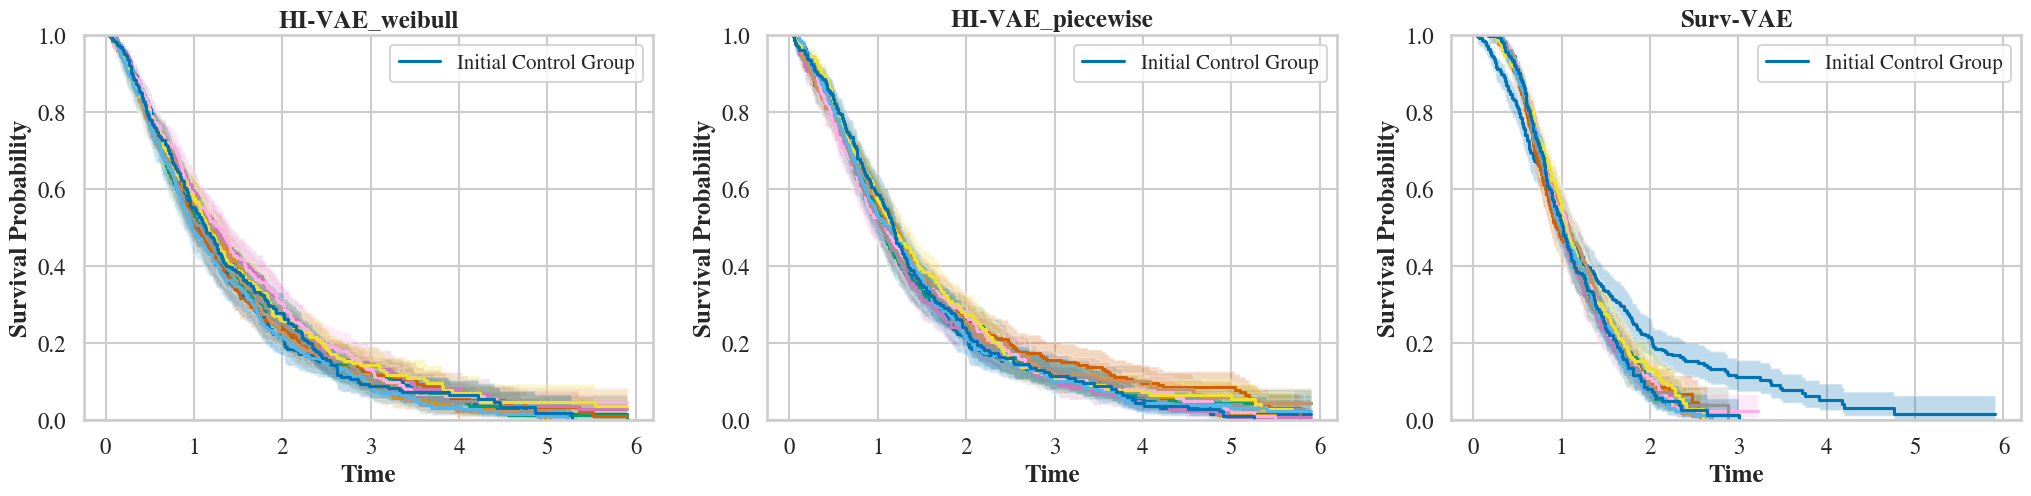

Monte-Carlo experiment 1
Epoch: [ 0]  time: 0.0556, ELBO_train: -16.05223465, KL_z: 2.47560835, KL_s: 0.10588455, reconstruction loss: -13.47074175
Epoch: [100]  time: 1.0705, ELBO_train: -12.44812012, KL_z: 1.22344947, KL_s: 0.03071928, reconstruction loss: -11.19395137
Epoch: [200]  time: 2.2139, ELBO_train: -12.02499962, KL_z: 1.24834323, KL_s: 0.01961994, reconstruction loss: -10.75703645
Epoch: [300]  time: 3.2144, ELBO_train: -11.78171635, KL_z: 1.30204606, KL_s: 0.01648951, reconstruction loss: -10.46318078
Epoch: [400]  time: 4.1349, ELBO_train: -11.88012600, KL_z: 1.31982946, KL_s: 0.01634836, reconstruction loss: -10.54394817
Epoch: [500]  time: 5.0373, ELBO_train: -11.99491119, KL_z: 1.46077812, KL_s: 0.01607752, reconstruction loss: -10.51805556
Epoch: [600]  time: 5.9014, ELBO_train: -11.52079296, KL_z: 1.57305110, KL_s: 0.01651764, reconstruction loss: -9.93122423
Epoch: [700]  time: 6.7427, ELBO_train: -11.92303371, KL_z: 1.70616221, KL_s: 0.01673317, reconstruction loss

[2025-06-26T11:24:38.646513+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:24:38.671234+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:12<00:00, 31.49it/s]


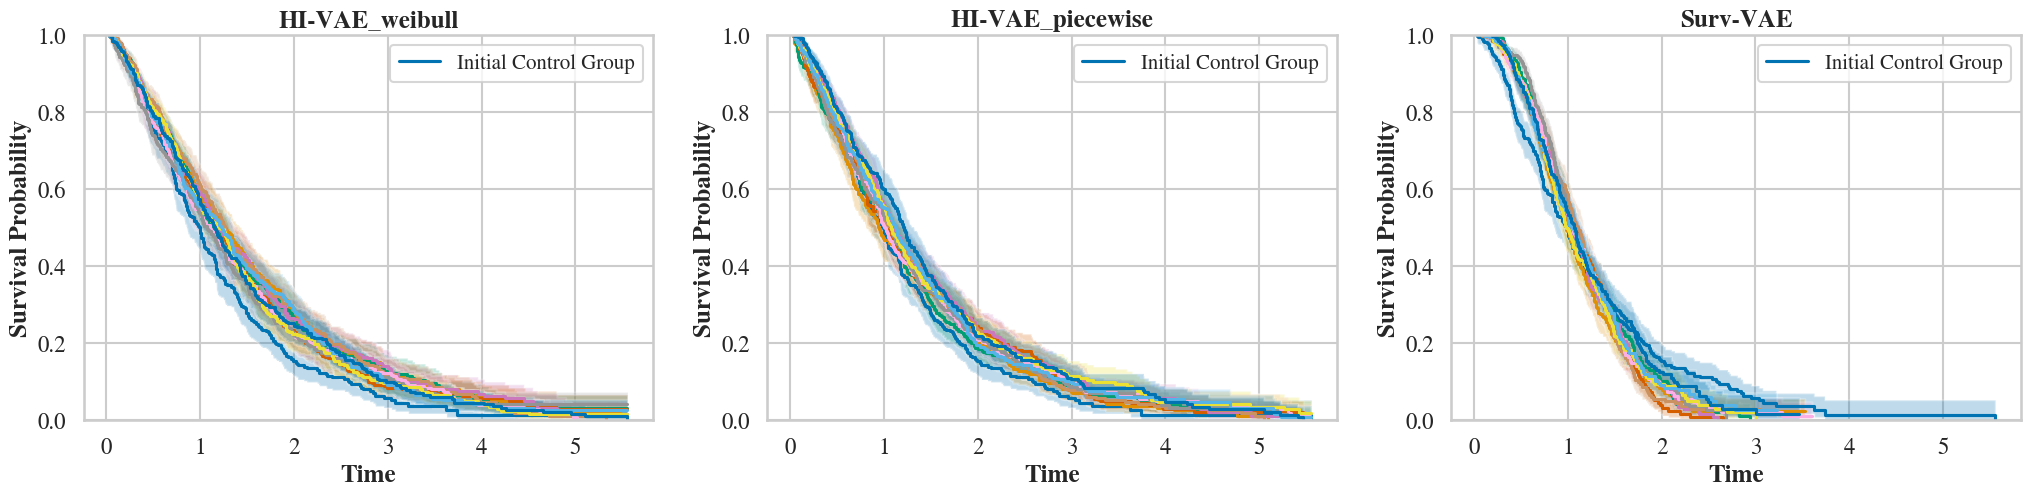

Monte-Carlo experiment 2
Epoch: [ 0]  time: 0.0451, ELBO_train: -16.11822319, KL_z: 2.45263934, KL_s: 0.10454798, reconstruction loss: -13.56103587
Epoch: [100]  time: 0.9073, ELBO_train: -12.21209621, KL_z: 1.17360663, KL_s: 0.03069544, reconstruction loss: -11.00779414
Epoch: [200]  time: 1.7439, ELBO_train: -12.08947086, KL_z: 1.22042954, KL_s: 0.01765013, reconstruction loss: -10.85139120
Epoch: [300]  time: 2.5672, ELBO_train: -12.23841190, KL_z: 1.28970218, KL_s: 0.01511621, reconstruction loss: -10.93359351
Epoch: [400]  time: 3.4083, ELBO_train: -11.85536289, KL_z: 1.30829668, KL_s: 0.01483393, reconstruction loss: -10.53223228
Epoch: [500]  time: 4.2537, ELBO_train: -11.82771683, KL_z: 1.45240176, KL_s: 0.01397943, reconstruction loss: -10.36133564
Epoch: [600]  time: 5.1217, ELBO_train: -11.80228138, KL_z: 1.49273956, KL_s: 0.01514912, reconstruction loss: -10.29439270
Epoch: [700]  time: 5.9701, ELBO_train: -11.84546185, KL_z: 1.55018258, KL_s: 0.01427794, reconstruction los

[2025-06-26T11:27:46.549655+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:27:46.586562+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:09<00:00, 41.30it/s]


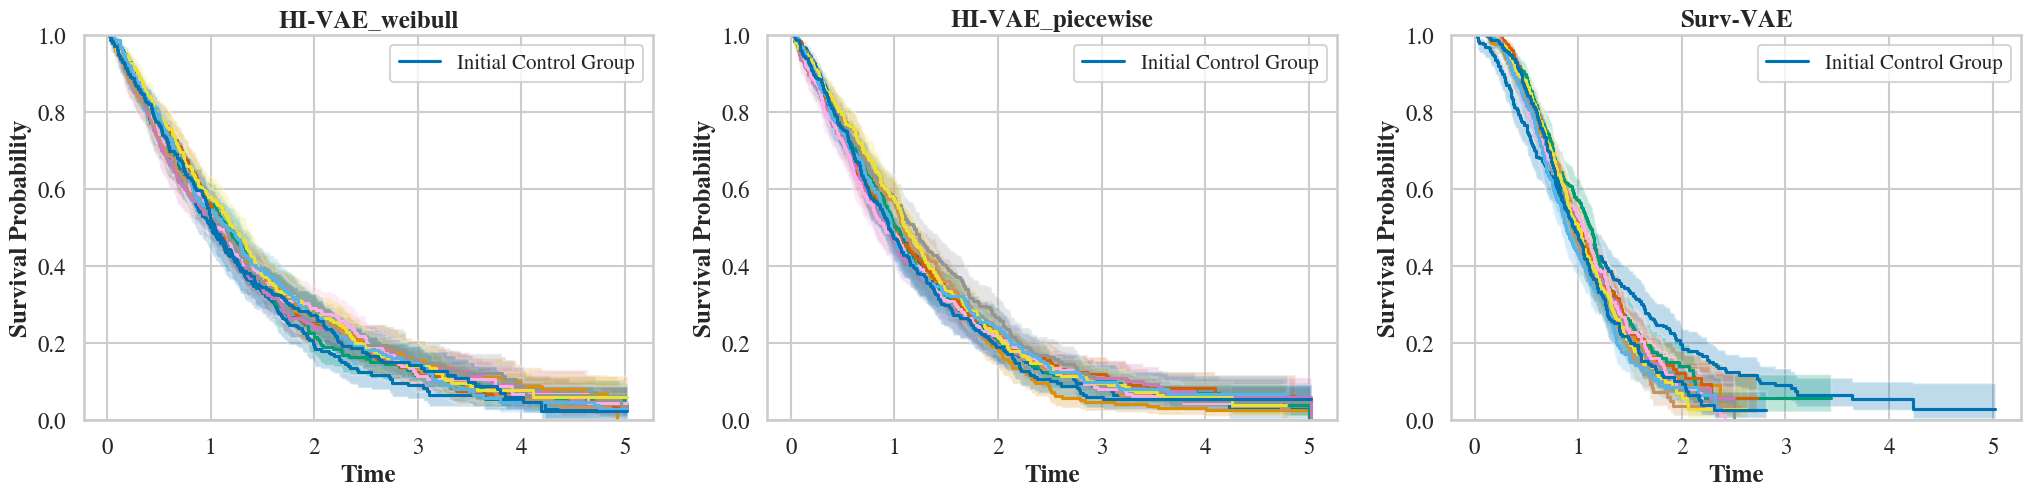

Monte-Carlo experiment 3
Epoch: [ 0]  time: 0.0489, ELBO_train: -16.43188667, KL_z: 2.43153405, KL_s: 0.10422516, reconstruction loss: -13.89612746
Epoch: [100]  time: 0.8569, ELBO_train: -12.36788082, KL_z: 1.22127211, KL_s: 0.03089714, reconstruction loss: -11.11571157
Epoch: [200]  time: 1.6283, ELBO_train: -11.99015045, KL_z: 1.29166651, KL_s: 0.01669931, reconstruction loss: -10.68178463
Epoch: [300]  time: 2.4295, ELBO_train: -12.15762138, KL_z: 1.31977952, KL_s: 0.01501703, reconstruction loss: -10.82282484
Epoch: [400]  time: 3.3250, ELBO_train: -12.14375305, KL_z: 1.37657332, KL_s: 0.01446009, reconstruction loss: -10.75271964
Epoch: [500]  time: 4.3095, ELBO_train: -11.86202812, KL_z: 1.46304476, KL_s: 0.01404381, reconstruction loss: -10.38493955
Epoch: [600]  time: 5.2869, ELBO_train: -11.82506752, KL_z: 1.59041560, KL_s: 0.01479435, reconstruction loss: -10.21985757
Epoch: [700]  time: 6.2434, ELBO_train: -11.76539040, KL_z: 1.66602683, KL_s: 0.01595402, reconstruction los

[2025-06-26T11:30:42.751543+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:30:42.772653+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:08<00:00, 47.37it/s]


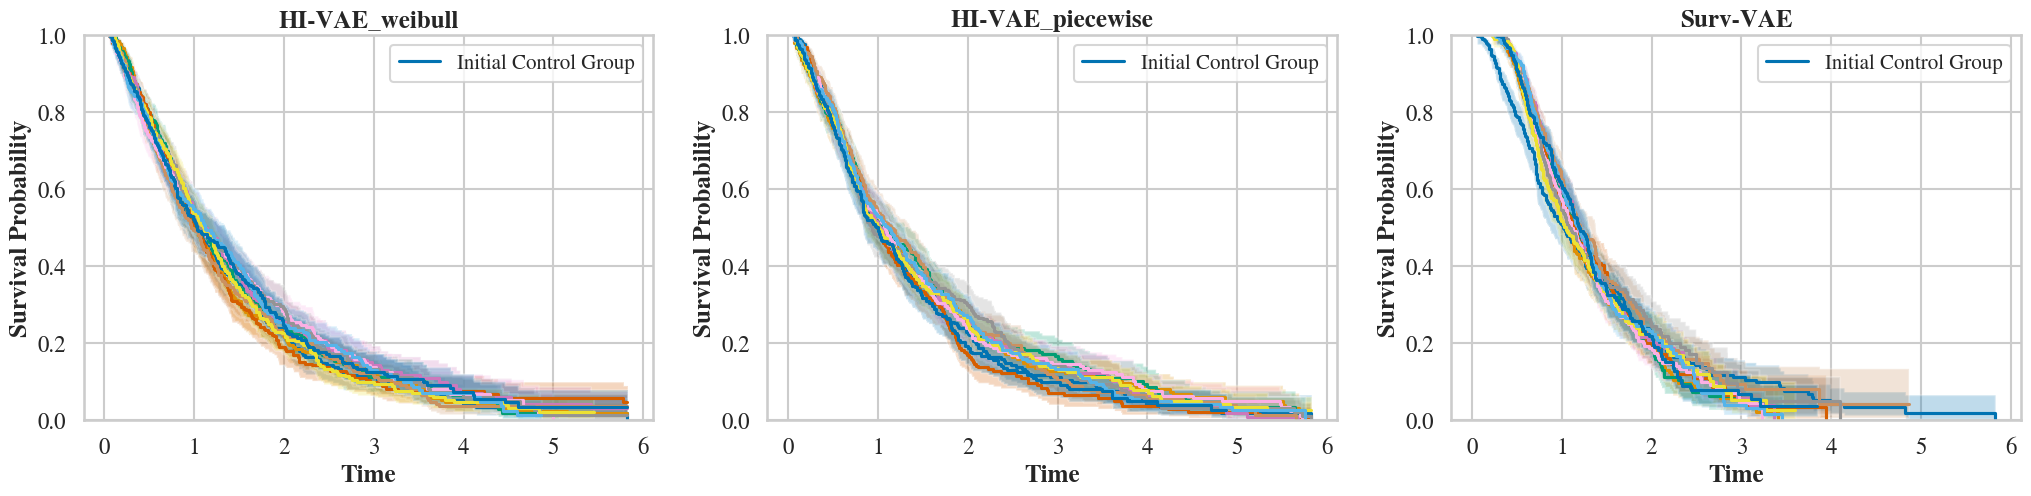

Monte-Carlo experiment 4
Epoch: [ 0]  time: 0.0188, ELBO_train: -16.14827347, KL_z: 2.47459340, KL_s: 0.10636902, reconstruction loss: -13.56731105
Epoch: [100]  time: 0.8491, ELBO_train: -12.18140984, KL_z: 1.23672760, KL_s: 0.02998066, reconstruction loss: -10.91470158
Epoch: [200]  time: 1.6444, ELBO_train: -12.20910740, KL_z: 1.27142417, KL_s: 0.01841307, reconstruction loss: -10.91927016
Epoch: [300]  time: 2.5094, ELBO_train: -11.98336315, KL_z: 1.31335688, KL_s: 0.01604176, reconstruction loss: -10.65396452
Epoch: [400]  time: 3.5114, ELBO_train: -11.97839069, KL_z: 1.38205171, KL_s: 0.01473951, reconstruction loss: -10.58159947
Epoch: [500]  time: 4.6343, ELBO_train: -12.19642353, KL_z: 1.44421315, KL_s: 0.01601171, reconstruction loss: -10.73619866
Epoch: [600]  time: 5.9629, ELBO_train: -11.88805199, KL_z: 1.57841218, KL_s: 0.01586819, reconstruction loss: -10.29377162
Epoch: [700]  time: 6.9918, ELBO_train: -11.76838112, KL_z: 1.63036299, KL_s: 0.01596785, reconstruction los

[2025-06-26T11:33:44.597120+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:33:44.616744+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:10<00:00, 38.26it/s]


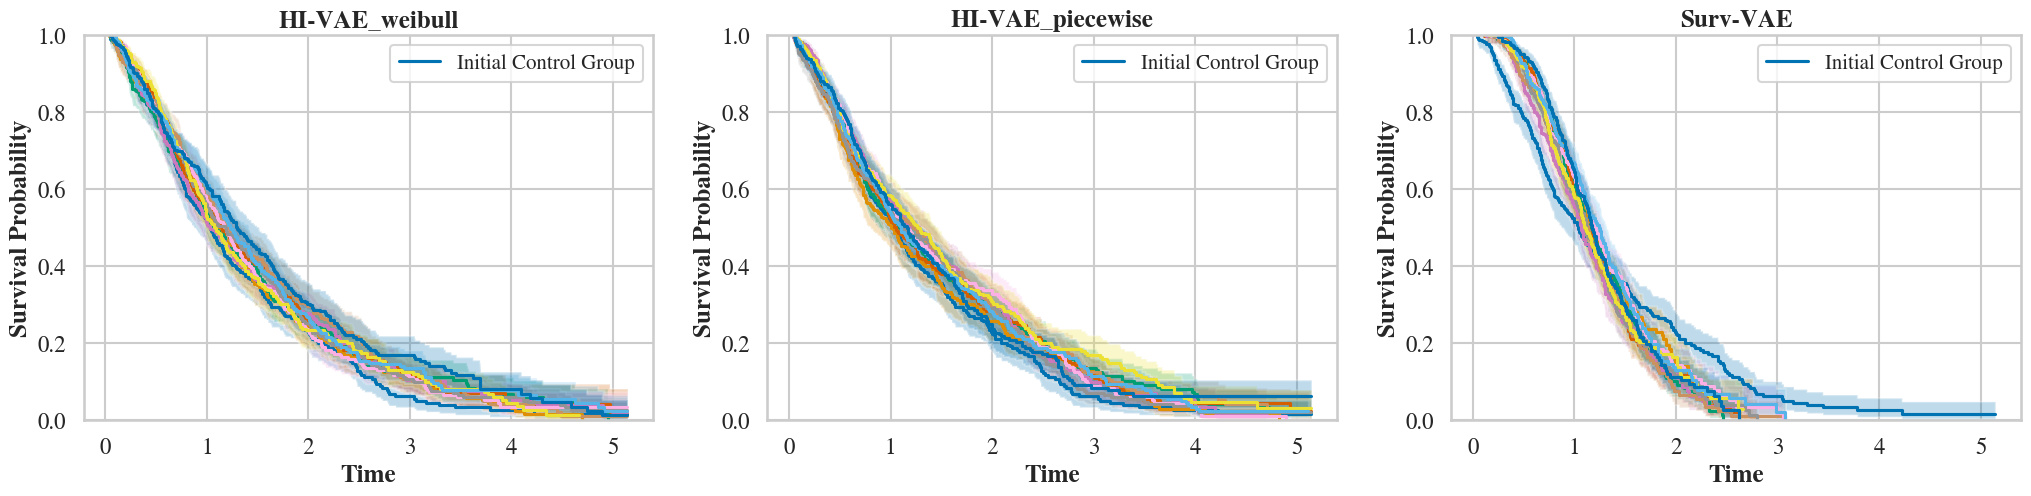

Monte-Carlo experiment 5
Epoch: [ 0]  time: 0.0555, ELBO_train: -15.64331436, KL_z: 2.45651817, KL_s: 0.10313129, reconstruction loss: -13.08366489
Epoch: [100]  time: 1.1454, ELBO_train: -12.24213505, KL_z: 1.25779200, KL_s: 0.02975845, reconstruction loss: -10.95458460
Epoch: [200]  time: 2.1742, ELBO_train: -11.21443844, KL_z: 1.28174794, KL_s: 0.01769972, reconstruction loss: -9.91499078
Epoch: [300]  time: 3.9046, ELBO_train: -11.52883339, KL_z: 1.31160903, KL_s: 0.01545143, reconstruction loss: -10.20177293
Epoch: [400]  time: 5.7765, ELBO_train: -11.20257950, KL_z: 1.38557923, KL_s: 0.01574278, reconstruction loss: -9.80125749
Epoch: [500]  time: 7.1980, ELBO_train: -11.11123180, KL_z: 1.42229593, KL_s: 0.01609659, reconstruction loss: -9.67283928
Epoch: [600]  time: 8.2965, ELBO_train: -11.31961632, KL_z: 1.52788329, KL_s: 0.01546860, reconstruction loss: -9.77626443
Epoch: [700]  time: 9.6728, ELBO_train: -11.26354027, KL_z: 1.64429629, KL_s: 0.01621437, reconstruction loss: -

[2025-06-26T11:37:09.570239+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:37:09.590946+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:10<00:00, 38.76it/s]


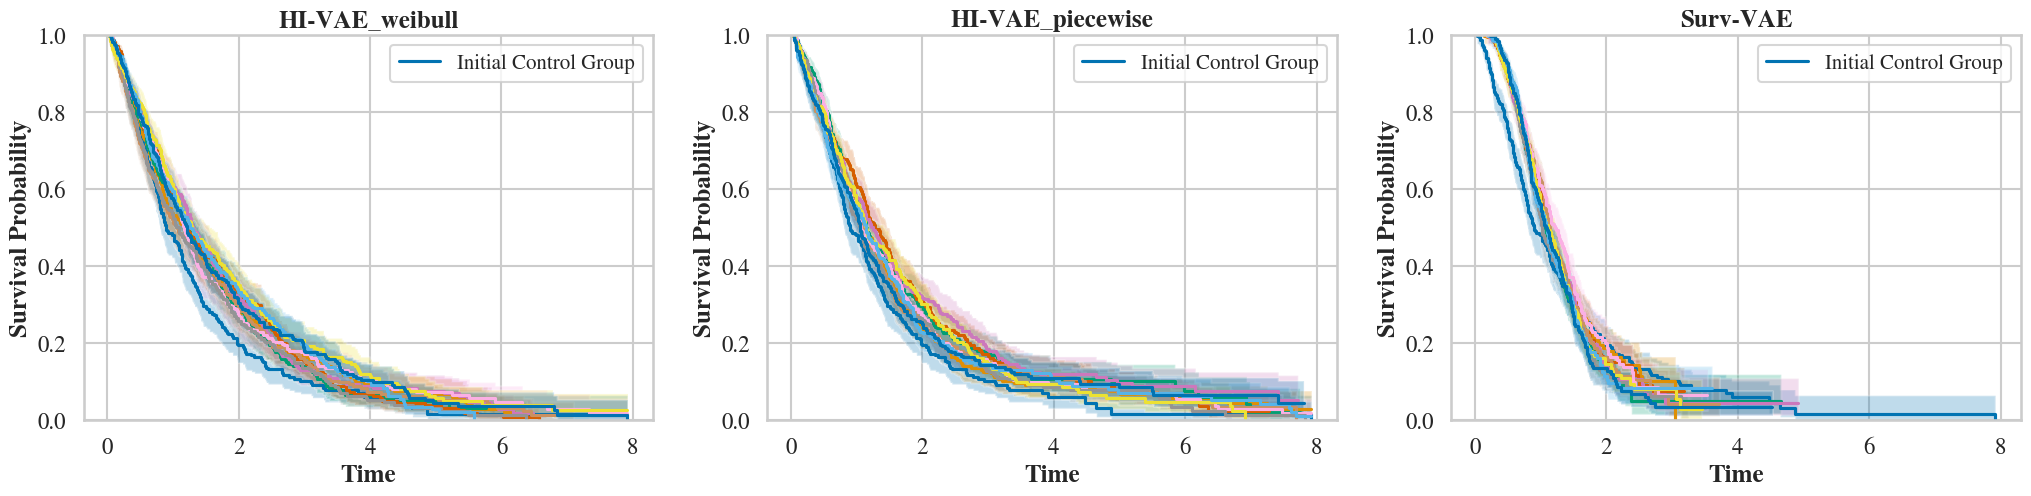

Monte-Carlo experiment 6
Epoch: [ 0]  time: 0.0105, ELBO_train: -16.06331444, KL_z: 2.45278144, KL_s: 0.10500669, reconstruction loss: -13.50552630
Epoch: [100]  time: 0.8074, ELBO_train: -12.18368912, KL_z: 1.26739550, KL_s: 0.03037882, reconstruction loss: -10.88591480
Epoch: [200]  time: 1.5811, ELBO_train: -11.97910690, KL_z: 1.28335977, KL_s: 0.01733923, reconstruction loss: -10.67840791
Epoch: [300]  time: 2.3782, ELBO_train: -12.18485069, KL_z: 1.35590374, KL_s: 0.01580191, reconstruction loss: -10.81314504
Epoch: [400]  time: 3.1640, ELBO_train: -11.78298759, KL_z: 1.40853715, KL_s: 0.01574421, reconstruction loss: -10.35870624
Epoch: [500]  time: 3.9547, ELBO_train: -11.70864773, KL_z: 1.46452200, KL_s: 0.01570129, reconstruction loss: -10.22842443
Epoch: [600]  time: 4.7427, ELBO_train: -11.38908195, KL_z: 1.55024600, KL_s: 0.01621199, reconstruction loss: -9.82262397
Epoch: [700]  time: 5.5447, ELBO_train: -11.55520058, KL_z: 1.63746285, KL_s: 0.01618052, reconstruction loss

[2025-06-26T11:40:21.118142+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:40:21.138092+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:08<00:00, 46.94it/s]


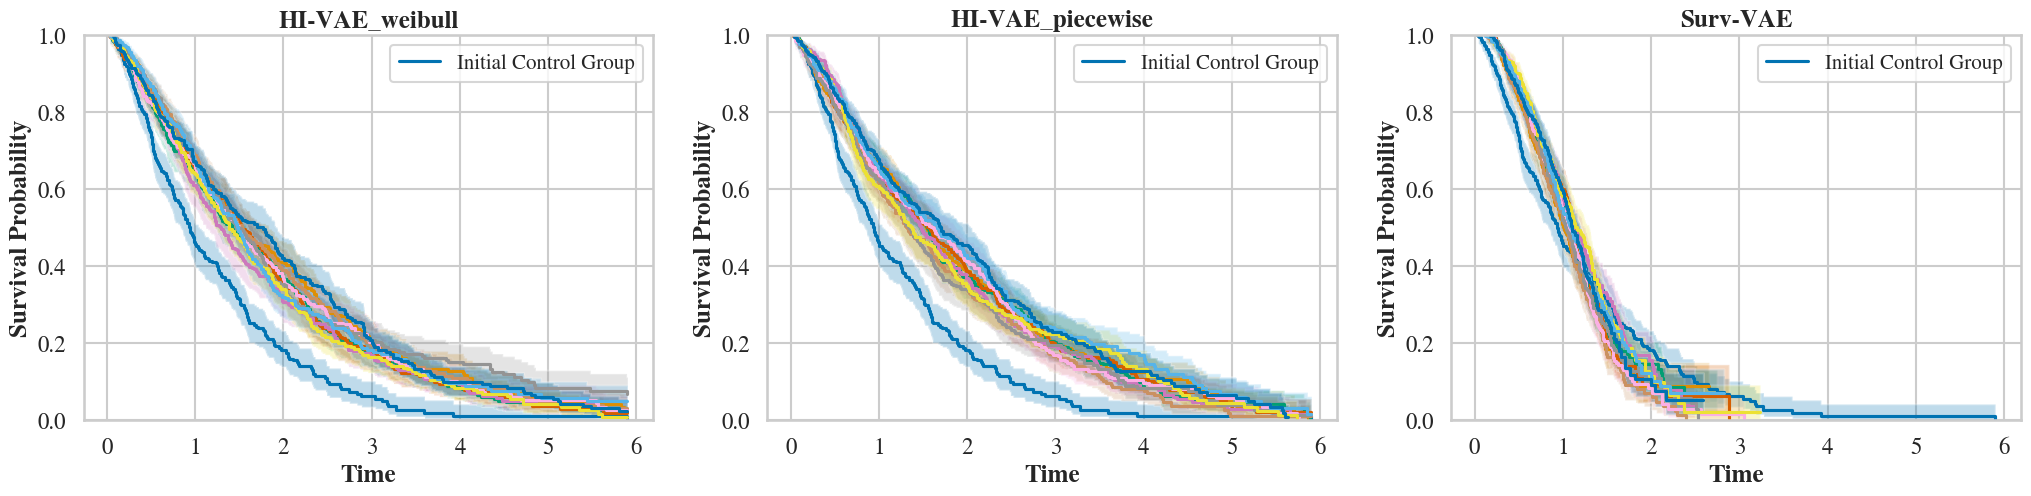

Monte-Carlo experiment 7
Epoch: [ 0]  time: 0.1100, ELBO_train: -15.92252922, KL_z: 2.46753788, KL_s: 0.10338211, reconstruction loss: -13.35160923
Epoch: [100]  time: 2.4249, ELBO_train: -12.06794071, KL_z: 1.22142088, KL_s: 0.03113127, reconstruction loss: -10.81538856
Epoch: [200]  time: 5.5690, ELBO_train: -11.93134403, KL_z: 1.27422702, KL_s: 0.01950502, reconstruction loss: -10.63761199
Epoch: [300]  time: 7.8142, ELBO_train: -12.03960228, KL_z: 1.39114857, KL_s: 0.01762104, reconstruction loss: -10.63083267
Epoch: [400]  time: 9.6091, ELBO_train: -11.65244389, KL_z: 1.44060528, KL_s: 0.01678896, reconstruction loss: -10.19504964
Epoch: [500]  time: 11.1455, ELBO_train: -12.31020737, KL_z: 1.48497045, KL_s: 0.01674747, reconstruction loss: -10.80848944
Epoch: [600]  time: 13.1929, ELBO_train: -11.32072830, KL_z: 1.57708335, KL_s: 0.01658535, reconstruction loss: -9.72705960
Epoch: [700]  time: 15.2114, ELBO_train: -11.26955032, KL_z: 1.71024334, KL_s: 0.01613235, reconstruction l

[2025-06-26T11:44:08.725997+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:44:08.751935+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:12<00:00, 31.64it/s]


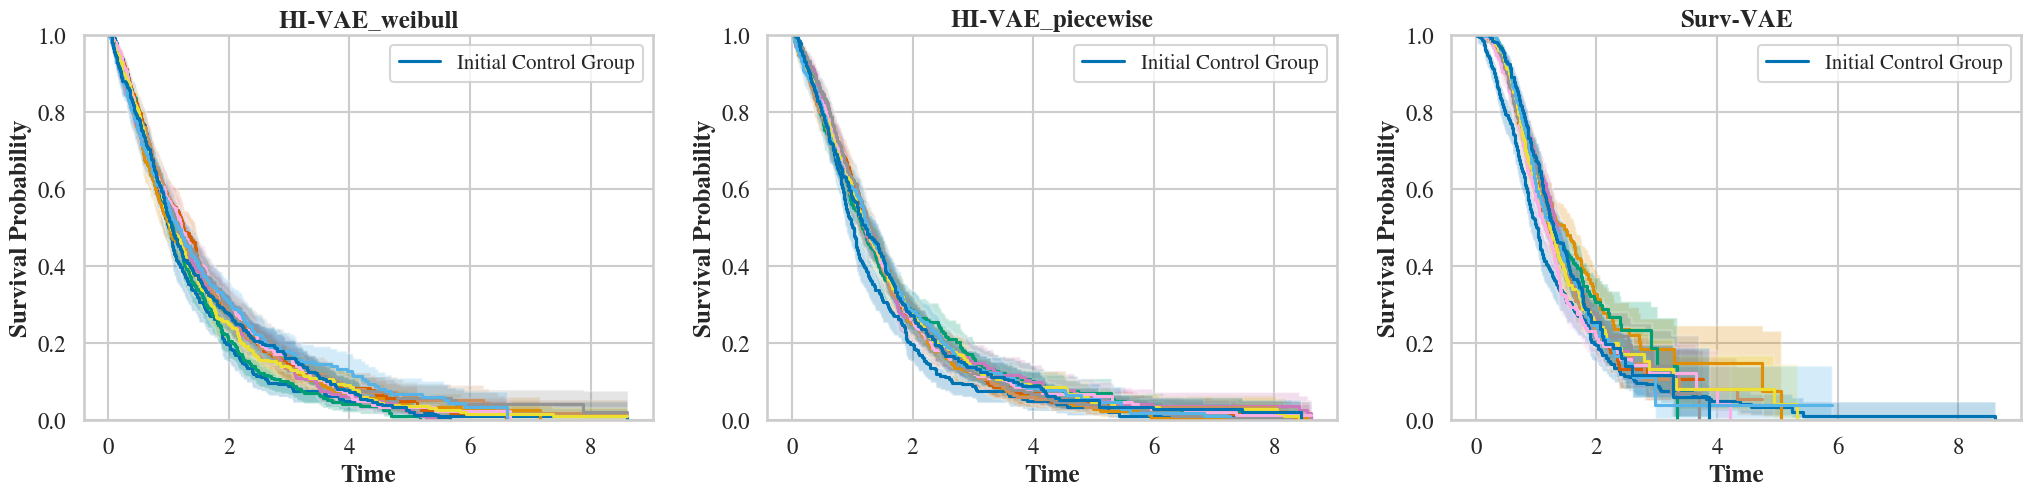

Monte-Carlo experiment 8
Epoch: [ 0]  time: 0.1033, ELBO_train: -15.67770481, KL_z: 2.44388700, KL_s: 0.10401344, reconstruction loss: -13.12980437
Epoch: [100]  time: 2.0027, ELBO_train: -12.28453541, KL_z: 1.17328131, KL_s: 0.03045797, reconstruction loss: -11.08079612
Epoch: [200]  time: 4.0473, ELBO_train: -11.83337116, KL_z: 1.26848054, KL_s: 0.01659298, reconstruction loss: -10.54829764
Epoch: [300]  time: 5.7687, ELBO_train: -12.11230850, KL_z: 1.29925108, KL_s: 0.01330137, reconstruction loss: -10.79975605
Epoch: [400]  time: 7.5810, ELBO_train: -11.77049446, KL_z: 1.39424920, KL_s: 0.01239920, reconstruction loss: -10.36384606
Epoch: [500]  time: 9.4261, ELBO_train: -11.57108593, KL_z: 1.41722071, KL_s: 0.01228046, reconstruction loss: -10.14158475
Epoch: [600]  time: 11.3913, ELBO_train: -11.35716248, KL_z: 1.58042800, KL_s: 0.01266193, reconstruction loss: -9.76407254
Epoch: [700]  time: 13.1401, ELBO_train: -11.68448067, KL_z: 1.53066456, KL_s: 0.01370811, reconstruction lo

[2025-06-26T11:47:36.787432+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:47:36.809960+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:11<00:00, 34.55it/s]


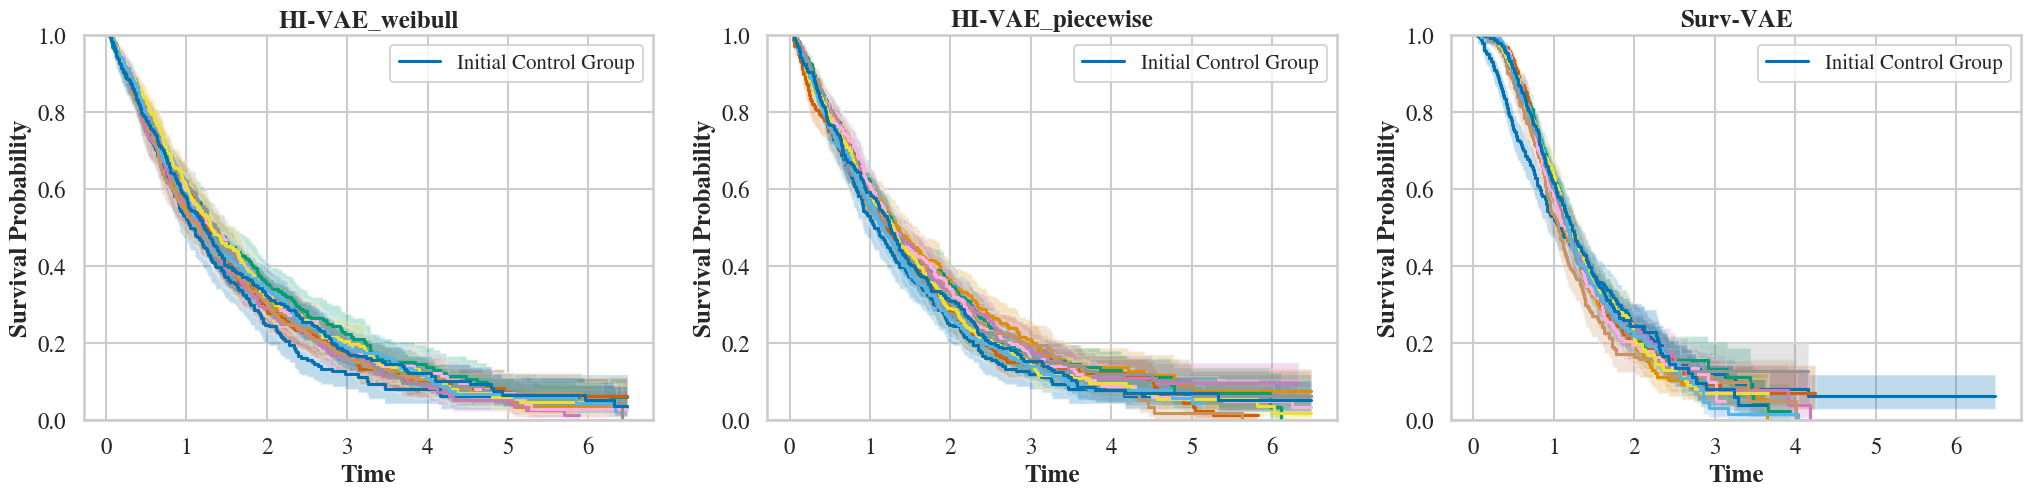

Monte-Carlo experiment 9
Epoch: [ 0]  time: 0.1477, ELBO_train: -16.05421066, KL_z: 2.43661809, KL_s: 0.10468483, reconstruction loss: -13.51290774
Epoch: [100]  time: 2.0343, ELBO_train: -12.23715687, KL_z: 1.19248712, KL_s: 0.03091574, reconstruction loss: -11.01375401
Epoch: [200]  time: 3.8266, ELBO_train: -12.12307358, KL_z: 1.22034228, KL_s: 0.01940155, reconstruction loss: -10.88332975
Epoch: [300]  time: 5.6375, ELBO_train: -12.05498314, KL_z: 1.25951731, KL_s: 0.01741171, reconstruction loss: -10.77805412
Epoch: [400]  time: 7.0867, ELBO_train: -12.13631153, KL_z: 1.34160328, KL_s: 0.01639795, reconstruction loss: -10.77831030
Epoch: [500]  time: 8.7228, ELBO_train: -11.68800449, KL_z: 1.44162118, KL_s: 0.01768780, reconstruction loss: -10.22869551
Epoch: [600]  time: 10.3230, ELBO_train: -11.60746002, KL_z: 1.59746361, KL_s: 0.01738167, reconstruction loss: -9.99261475
Epoch: [700]  time: 12.0993, ELBO_train: -11.75528431, KL_z: 1.67116332, KL_s: 0.01757956, reconstruction lo

[2025-06-26T11:51:24.445887+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:51:24.468474+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:10<00:00, 38.13it/s]


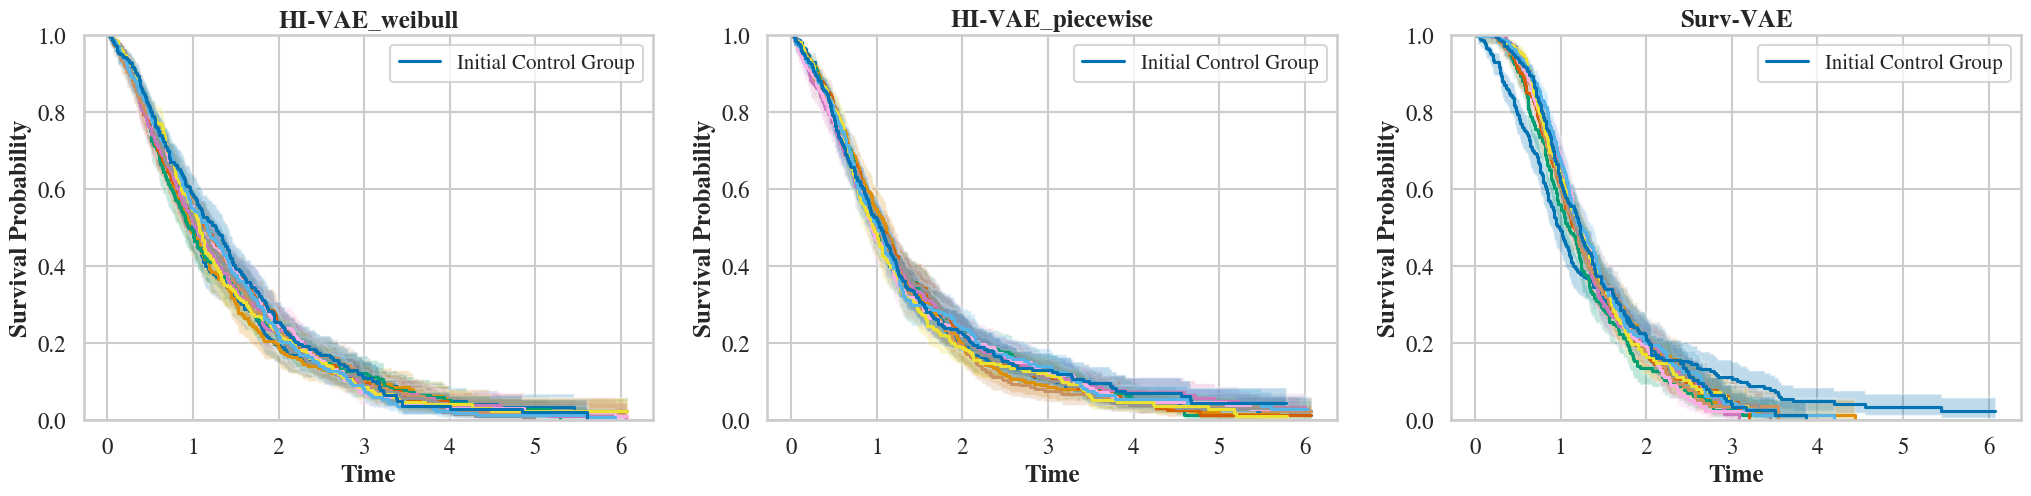

Monte-Carlo experiment 10
Epoch: [ 0]  time: 0.0209, ELBO_train: -16.60755157, KL_z: 2.46153474, KL_s: 0.10505962, reconstruction loss: -14.04095721
Epoch: [100]  time: 1.5131, ELBO_train: -12.34016132, KL_z: 1.24150133, KL_s: 0.03067923, reconstruction loss: -11.06798077
Epoch: [200]  time: 3.7319, ELBO_train: -12.41144753, KL_z: 1.32376182, KL_s: 0.01808977, reconstruction loss: -11.06959593
Epoch: [300]  time: 5.3596, ELBO_train: -12.28085423, KL_z: 1.36988902, KL_s: 0.01559544, reconstruction loss: -10.89536977
Epoch: [400]  time: 7.0948, ELBO_train: -12.11514473, KL_z: 1.41882360, KL_s: 0.01478529, reconstruction loss: -10.68153584
Epoch: [500]  time: 8.8544, ELBO_train: -12.21097946, KL_z: 1.44403791, KL_s: 0.01524258, reconstruction loss: -10.75169897
Epoch: [600]  time: 10.5923, ELBO_train: -12.07335567, KL_z: 1.50155067, KL_s: 0.01584244, reconstruction loss: -10.55596256
Epoch: [700]  time: 12.4551, ELBO_train: -11.90172482, KL_z: 1.58642340, KL_s: 0.01624298, reconstruction 

[2025-06-26T11:54:59.958039+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:54:59.997121+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:10<00:00, 39.00it/s]


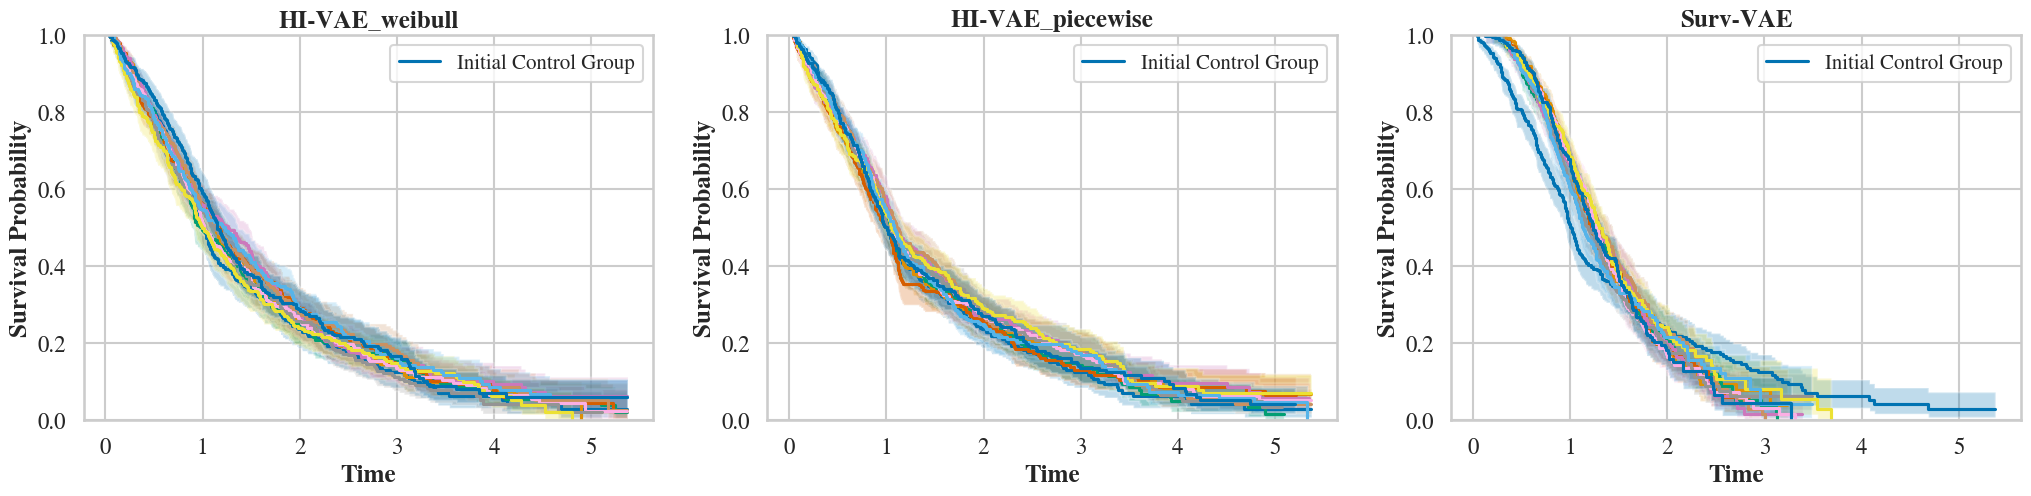

Monte-Carlo experiment 11
Epoch: [ 0]  time: 0.0228, ELBO_train: -16.12538528, KL_z: 2.46250057, KL_s: 0.10521078, reconstruction loss: -13.55767393
Epoch: [100]  time: 0.9406, ELBO_train: -12.14068890, KL_z: 1.27494681, KL_s: 0.03011608, reconstruction loss: -10.83562601
Epoch: [200]  time: 1.9538, ELBO_train: -12.15526295, KL_z: 1.31898439, KL_s: 0.01842213, reconstruction loss: -10.81785643
Epoch: [300]  time: 3.6012, ELBO_train: -12.34605408, KL_z: 1.40459025, KL_s: 0.01708317, reconstruction loss: -10.92438066
Epoch: [400]  time: 5.2181, ELBO_train: -11.57270336, KL_z: 1.44041562, KL_s: 0.01646566, reconstruction loss: -10.11582208
Epoch: [500]  time: 6.4301, ELBO_train: -11.67401791, KL_z: 1.50209081, KL_s: 0.01609278, reconstruction loss: -10.15583432
Epoch: [600]  time: 7.8468, ELBO_train: -11.45356083, KL_z: 1.59403276, KL_s: 0.01698637, reconstruction loss: -9.84254169
Epoch: [700]  time: 9.2246, ELBO_train: -11.66858196, KL_z: 1.75883961, KL_s: 0.01764917, reconstruction los

[2025-06-26T11:58:35.755356+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T11:58:35.774351+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:08<00:00, 44.75it/s]


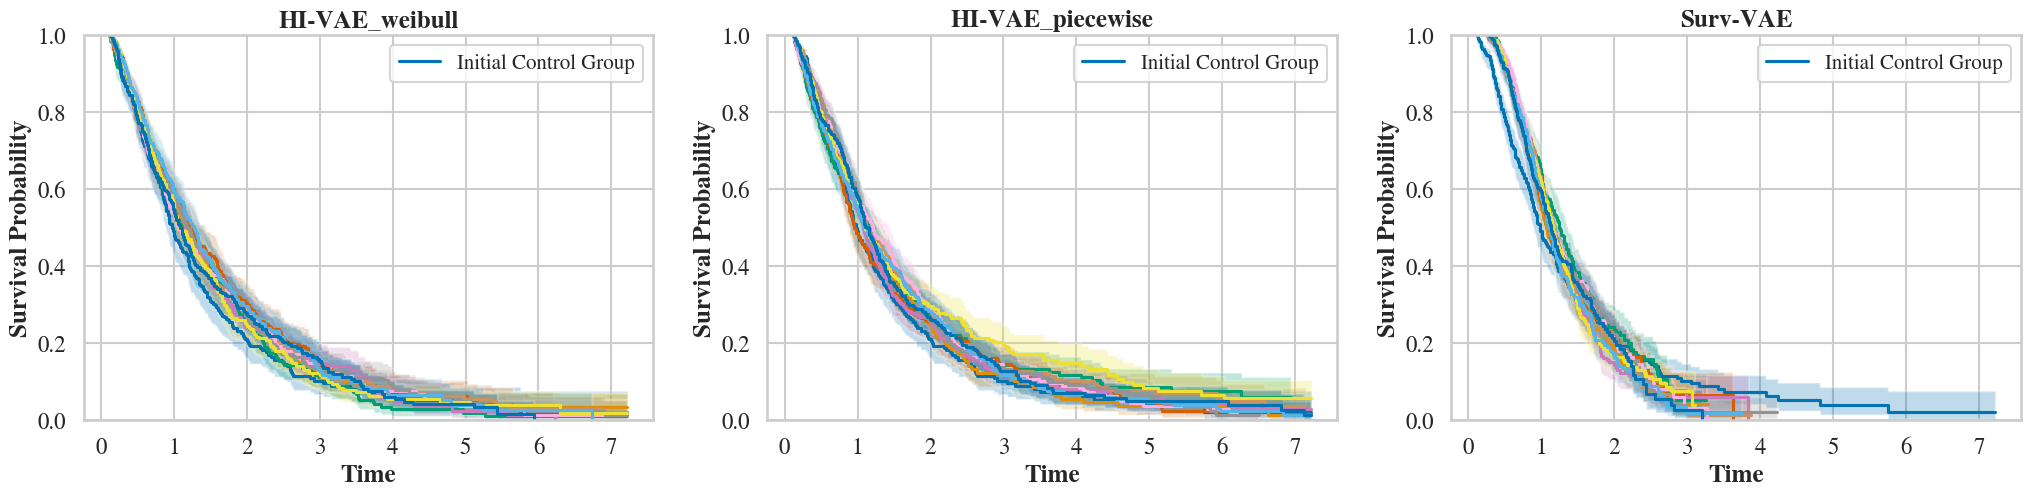

Monte-Carlo experiment 12
Epoch: [ 0]  time: 0.0114, ELBO_train: -16.37763977, KL_z: 2.46494675, KL_s: 0.10573816, reconstruction loss: -13.80695486
Epoch: [100]  time: 0.8749, ELBO_train: -12.50750828, KL_z: 1.25917482, KL_s: 0.03026628, reconstruction loss: -11.21806717
Epoch: [200]  time: 1.6851, ELBO_train: -12.25853825, KL_z: 1.30727541, KL_s: 0.01944017, reconstruction loss: -10.93182266
Epoch: [300]  time: 2.4861, ELBO_train: -12.00112152, KL_z: 1.34756041, KL_s: 0.01752949, reconstruction loss: -10.63603163
Epoch: [400]  time: 3.2895, ELBO_train: -12.09113216, KL_z: 1.34181809, KL_s: 0.01772451, reconstruction loss: -10.73158956
Epoch: [500]  time: 4.1258, ELBO_train: -11.54757786, KL_z: 1.39871657, KL_s: 0.01863050, reconstruction loss: -10.13023078
Epoch: [600]  time: 5.1700, ELBO_train: -11.61400318, KL_z: 1.39888561, KL_s: 0.01860428, reconstruction loss: -10.19651330
Epoch: [700]  time: 7.4878, ELBO_train: -11.45793724, KL_z: 1.39897752, KL_s: 0.01866245, reconstruction lo

[2025-06-26T12:01:40.154183+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:01:40.174539+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:09<00:00, 43.58it/s]


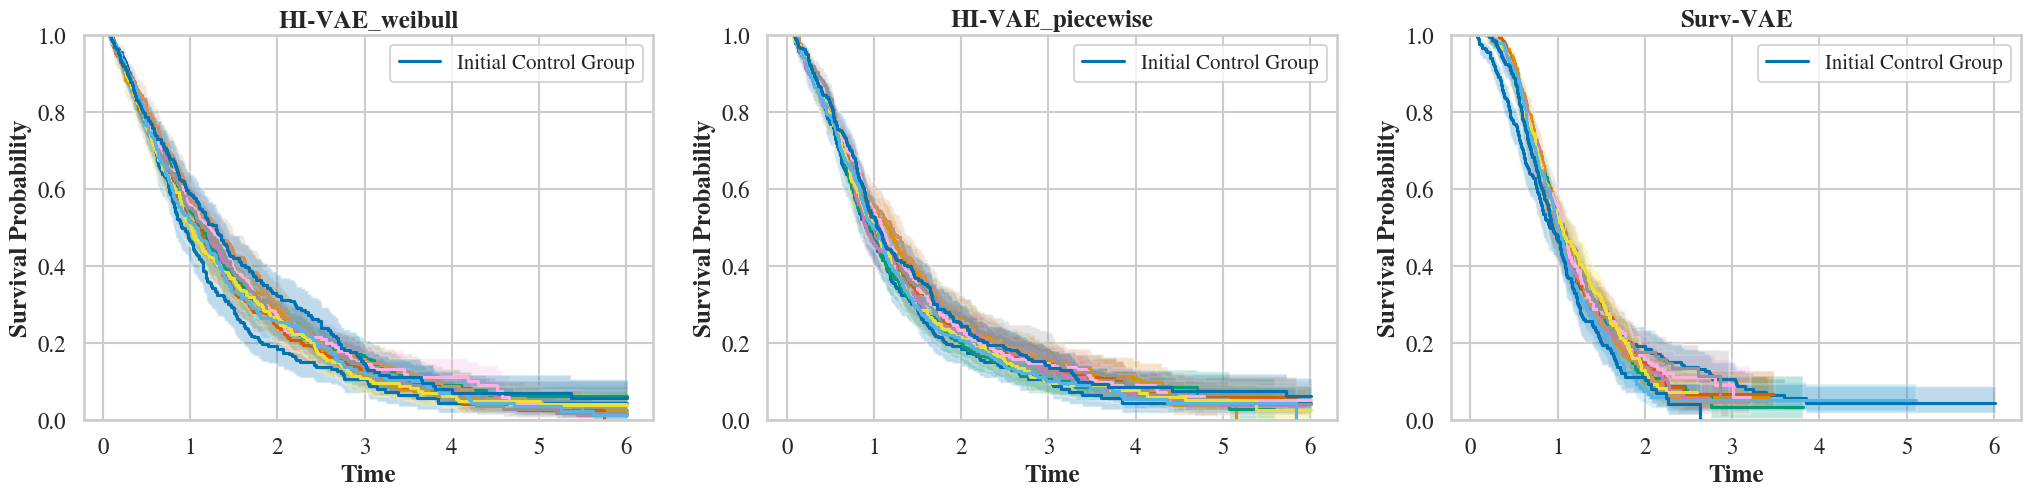

Monte-Carlo experiment 13
Epoch: [ 0]  time: 0.0112, ELBO_train: -16.16849136, KL_z: 2.47559476, KL_s: 0.10441732, reconstruction loss: -13.58847928
Epoch: [100]  time: 1.1630, ELBO_train: -12.61491203, KL_z: 1.26107848, KL_s: 0.03040743, reconstruction loss: -11.32342613
Epoch: [200]  time: 2.4318, ELBO_train: -12.20629501, KL_z: 1.31367934, KL_s: 0.01600599, reconstruction loss: -10.87660968
Epoch: [300]  time: 4.3298, ELBO_train: -12.21089363, KL_z: 1.35163903, KL_s: 0.01335478, reconstruction loss: -10.84589982
Epoch: [400]  time: 5.7778, ELBO_train: -11.89796925, KL_z: 1.40227723, KL_s: 0.01360369, reconstruction loss: -10.48208833
Epoch: [500]  time: 6.9689, ELBO_train: -11.60257149, KL_z: 1.48836601, KL_s: 0.01351738, reconstruction loss: -10.10068810
Epoch: [600]  time: 8.4341, ELBO_train: -11.45945358, KL_z: 1.66290009, KL_s: 0.01456308, reconstruction loss: -9.78199041
Epoch: [700]  time: 9.6374, ELBO_train: -11.51952553, KL_z: 1.70714617, KL_s: 0.01418304, reconstruction los

[2025-06-26T12:04:59.153636+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:04:59.173672+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:09<00:00, 42.16it/s]


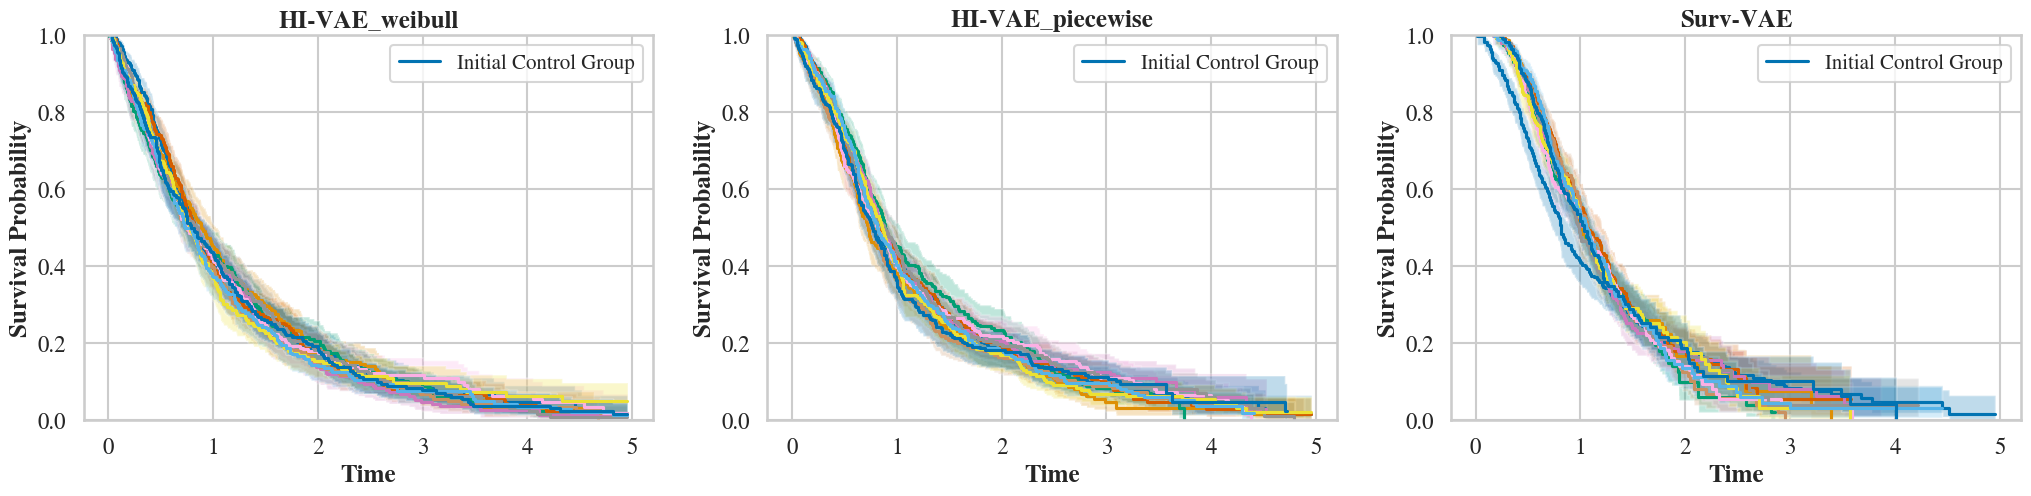

Monte-Carlo experiment 14
Epoch: [ 0]  time: 0.3414, ELBO_train: -16.46343803, KL_z: 2.44902992, KL_s: 0.10398054, reconstruction loss: -13.91042757
Epoch: [100]  time: 1.9720, ELBO_train: -12.21949863, KL_z: 1.20764923, KL_s: 0.03086853, reconstruction loss: -10.98098087
Epoch: [200]  time: 3.4597, ELBO_train: -11.83885098, KL_z: 1.26833344, KL_s: 0.01718426, reconstruction loss: -10.55333328
Epoch: [300]  time: 4.7345, ELBO_train: -12.41949081, KL_z: 1.28896117, KL_s: 0.01521254, reconstruction loss: -11.11531711
Epoch: [400]  time: 6.4887, ELBO_train: -11.79338551, KL_z: 1.37062967, KL_s: 0.01428127, reconstruction loss: -10.40847456
Epoch: [500]  time: 7.6985, ELBO_train: -11.81222916, KL_z: 1.38411784, KL_s: 0.01493931, reconstruction loss: -10.41317201
Epoch: [600]  time: 9.2760, ELBO_train: -11.74381065, KL_z: 1.41340292, KL_s: 0.01477671, reconstruction loss: -10.31563103
Early stopping at epoch 600.
Training finished.
Epoch: [ 0]  time: 0.0257, ELBO_train: -14.97764492, KL_z: 

[2025-06-26T12:08:18.049828+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:08:18.068811+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:08<00:00, 44.90it/s]


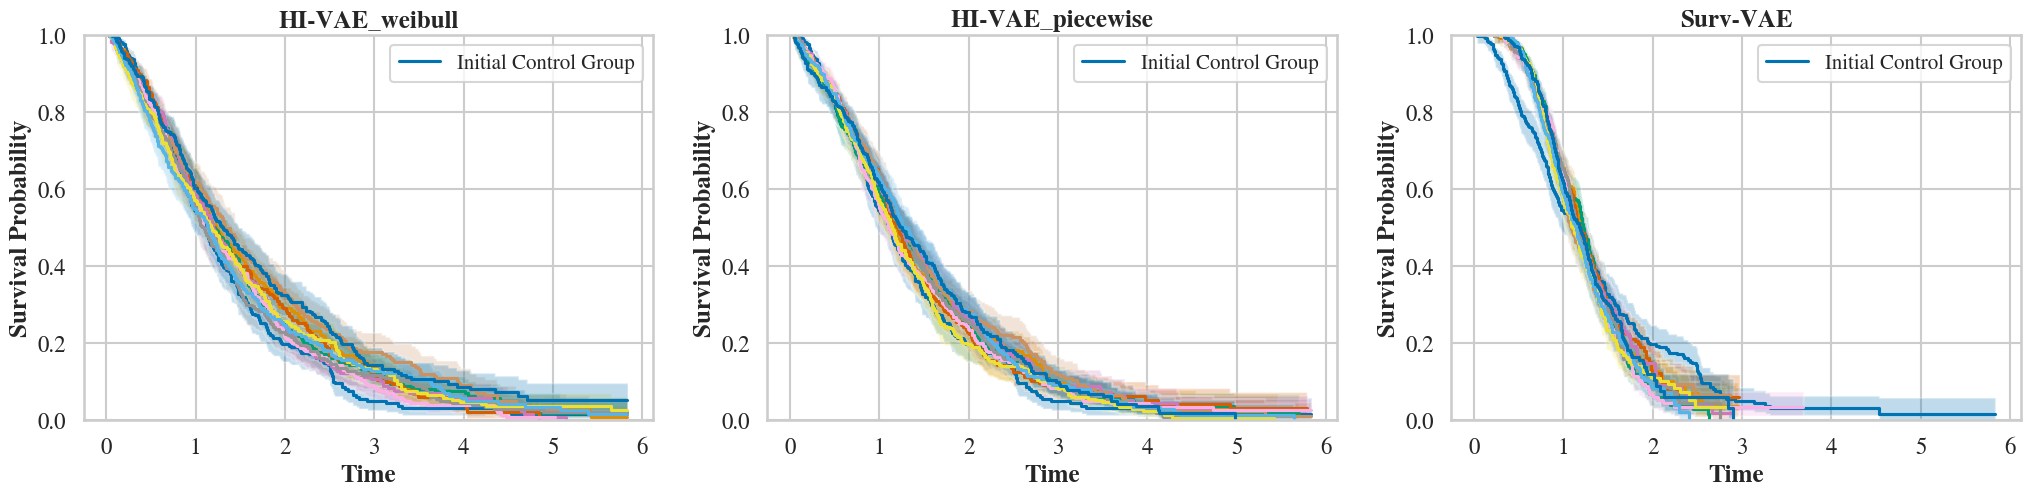

Monte-Carlo experiment 15
Epoch: [ 0]  time: 0.0231, ELBO_train: -15.96093655, KL_z: 2.49397969, KL_s: 0.10427570, reconstruction loss: -13.36268115
Epoch: [100]  time: 0.7992, ELBO_train: -12.15686893, KL_z: 1.20314038, KL_s: 0.03010941, reconstruction loss: -10.92361915
Epoch: [200]  time: 1.5001, ELBO_train: -12.24485302, KL_z: 1.27400589, KL_s: 0.01737690, reconstruction loss: -10.95347023
Epoch: [300]  time: 2.2190, ELBO_train: -11.96364498, KL_z: 1.36821139, KL_s: 0.01479530, reconstruction loss: -10.58063829
Epoch: [400]  time: 2.9654, ELBO_train: -11.84945202, KL_z: 1.43983388, KL_s: 0.01416254, reconstruction loss: -10.39545560
Epoch: [500]  time: 3.7792, ELBO_train: -11.70925140, KL_z: 1.53334451, KL_s: 0.01493883, reconstruction loss: -10.16096807
Epoch: [600]  time: 4.6362, ELBO_train: -11.56574726, KL_z: 1.57140994, KL_s: 0.01549053, reconstruction loss: -9.97884679
Epoch: [700]  time: 5.5020, ELBO_train: -11.62230873, KL_z: 1.63511300, KL_s: 0.01533556, reconstruction los

[2025-06-26T12:10:57.486734+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:10:57.507593+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:07<00:00, 51.46it/s]


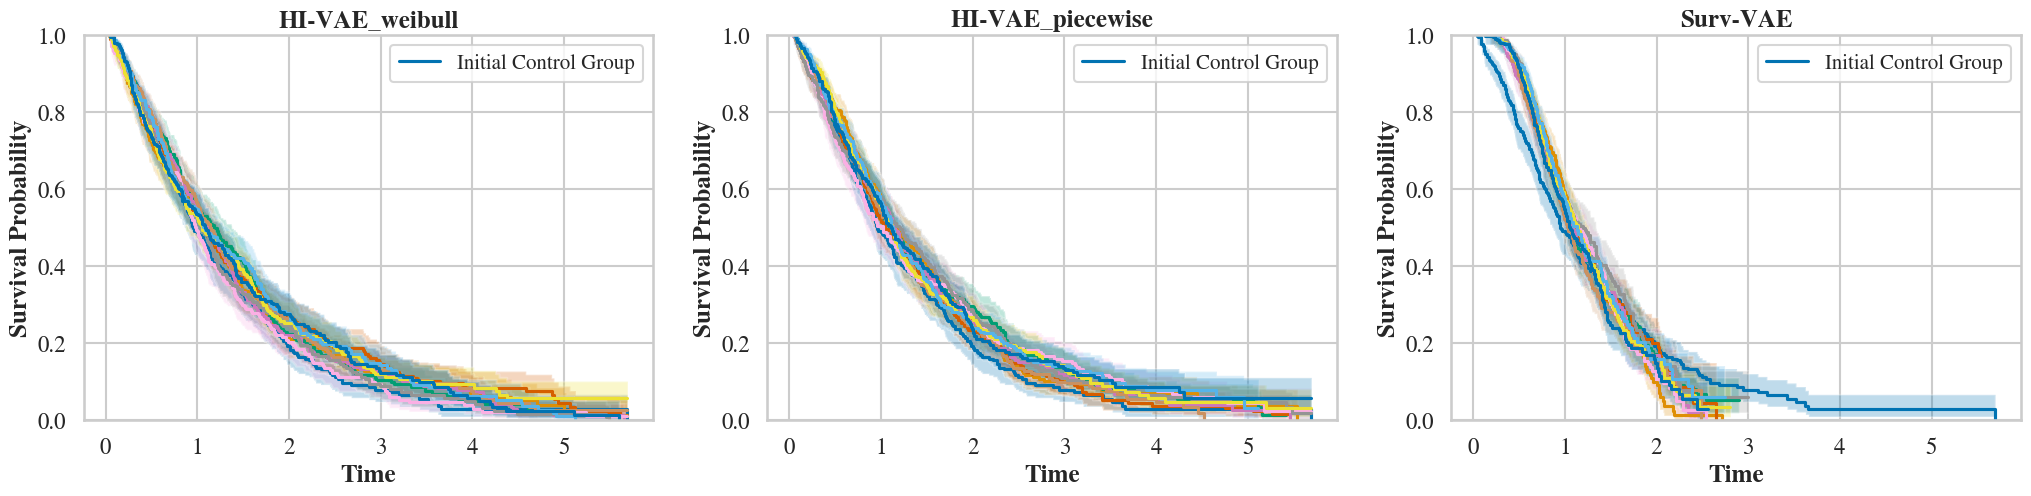

Monte-Carlo experiment 16
Epoch: [ 0]  time: 0.0116, ELBO_train: -16.15796852, KL_z: 2.44359064, KL_s: 0.10486269, reconstruction loss: -13.60951519
Epoch: [100]  time: 0.7588, ELBO_train: -12.53855801, KL_z: 1.22562838, KL_s: 0.03088522, reconstruction loss: -11.28204441
Epoch: [200]  time: 1.4825, ELBO_train: -11.90119457, KL_z: 1.33948123, KL_s: 0.01834965, reconstruction loss: -10.54336369
Epoch: [300]  time: 2.2092, ELBO_train: -12.13114166, KL_z: 1.36011481, KL_s: 0.01497221, reconstruction loss: -10.75605464
Epoch: [400]  time: 2.9350, ELBO_train: -12.03215504, KL_z: 1.41286790, KL_s: 0.01516819, reconstruction loss: -10.60411894
Epoch: [500]  time: 3.6596, ELBO_train: -12.16503811, KL_z: 1.43951225, KL_s: 0.01459503, reconstruction loss: -10.71093082
Epoch: [600]  time: 4.3928, ELBO_train: -12.17429161, KL_z: 1.56341672, KL_s: 0.01497078, reconstruction loss: -10.59590411
Epoch: [700]  time: 5.1314, ELBO_train: -11.72056770, KL_z: 1.67572451, KL_s: 0.01505756, reconstruction lo

[2025-06-26T12:14:00.067753+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:14:00.095122+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:07<00:00, 53.95it/s]


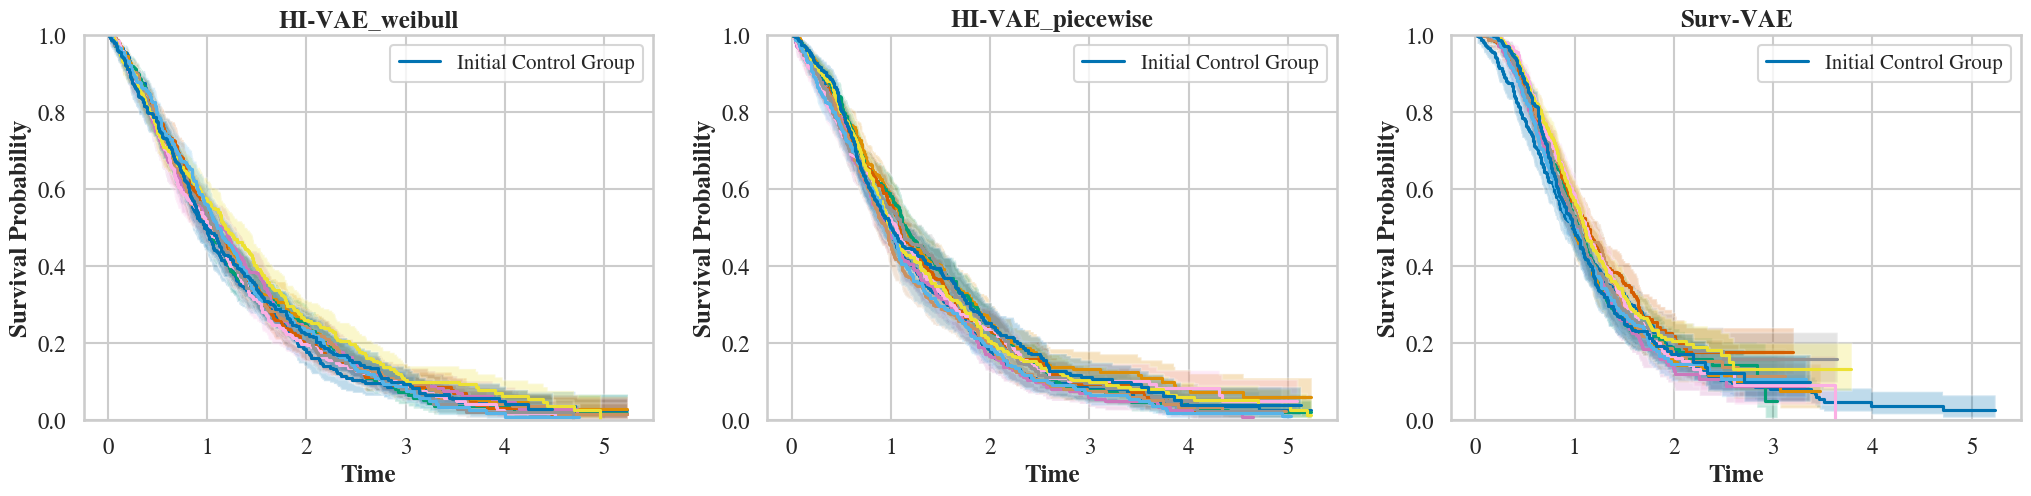

Monte-Carlo experiment 17
Epoch: [ 0]  time: 0.0197, ELBO_train: -16.09295845, KL_z: 2.45225620, KL_s: 0.10570431, reconstruction loss: -13.53499794
Epoch: [100]  time: 0.7517, ELBO_train: -12.63931465, KL_z: 1.27752197, KL_s: 0.03014231, reconstruction loss: -11.33165038
Epoch: [200]  time: 1.4779, ELBO_train: -12.03350544, KL_z: 1.32369757, KL_s: 0.01835632, reconstruction loss: -10.69145155
Epoch: [300]  time: 2.2463, ELBO_train: -11.98344707, KL_z: 1.33253491, KL_s: 0.01540041, reconstruction loss: -10.63551176
Epoch: [400]  time: 3.1198, ELBO_train: -11.77620411, KL_z: 1.39163280, KL_s: 0.01479101, reconstruction loss: -10.36978030
Epoch: [500]  time: 3.9948, ELBO_train: -11.87366581, KL_z: 1.42360449, KL_s: 0.01412439, reconstruction loss: -10.43593693
Epoch: [600]  time: 4.8879, ELBO_train: -11.91787338, KL_z: 1.44255674, KL_s: 0.01479435, reconstruction loss: -10.46052229
Early stopping at epoch 600.
Training finished.
Epoch: [ 0]  time: 0.0166, ELBO_train: -14.62242794, KL_z: 

[2025-06-26T12:16:37.618707+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:16:37.636455+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:07<00:00, 55.45it/s]


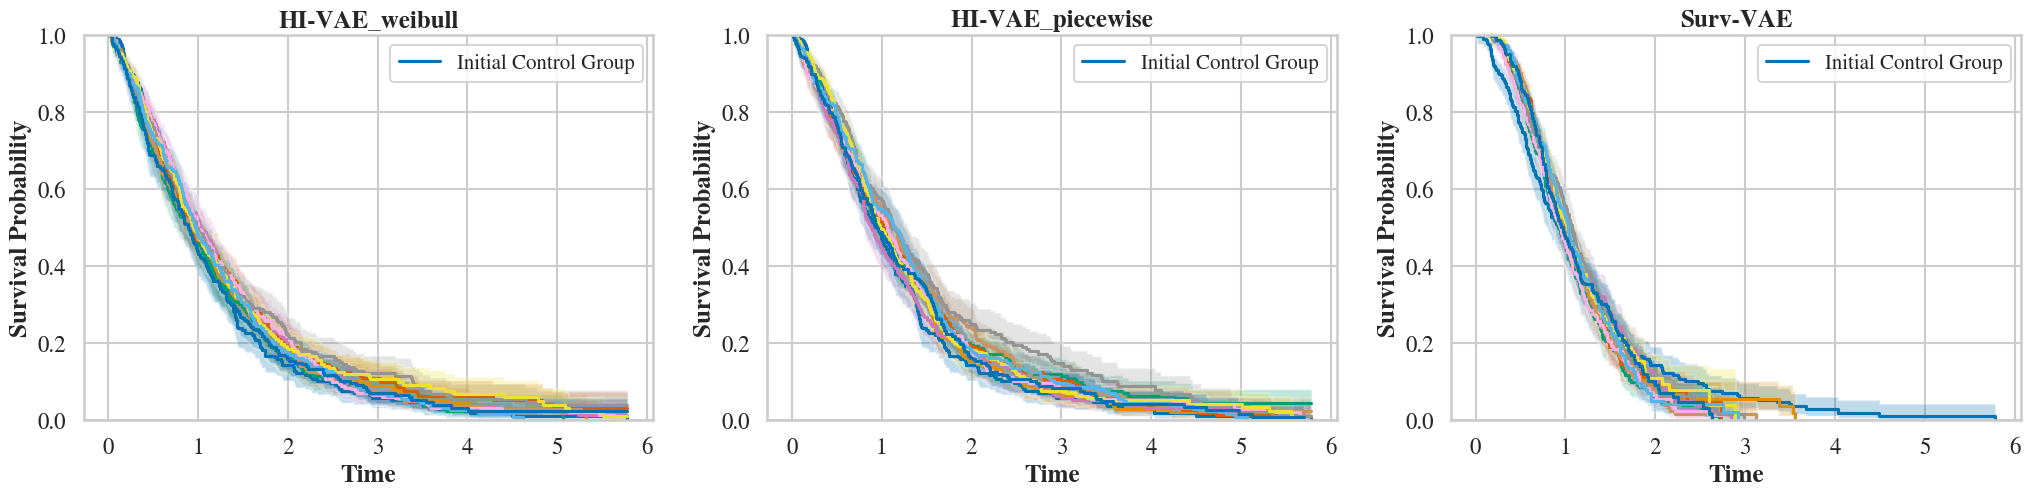

Monte-Carlo experiment 18
Epoch: [ 0]  time: 0.0098, ELBO_train: -16.50808334, KL_z: 2.45865846, KL_s: 0.10471344, reconstruction loss: -13.94471145
Epoch: [100]  time: 0.7434, ELBO_train: -12.99347305, KL_z: 1.25260329, KL_s: 0.03031778, reconstruction loss: -11.71055198
Epoch: [200]  time: 1.4611, ELBO_train: -12.27578640, KL_z: 1.27778423, KL_s: 0.01834059, reconstruction loss: -10.97966158
Epoch: [300]  time: 2.1790, ELBO_train: -12.42151260, KL_z: 1.28601527, KL_s: 0.01597357, reconstruction loss: -11.11952376
Epoch: [400]  time: 2.9704, ELBO_train: -12.37807655, KL_z: 1.41602159, KL_s: 0.01576090, reconstruction loss: -10.94629407
Epoch: [500]  time: 3.8416, ELBO_train: -12.23548412, KL_z: 1.43569541, KL_s: 0.01560450, reconstruction loss: -10.78418422
Epoch: [600]  time: 4.7569, ELBO_train: -11.94719219, KL_z: 1.55131125, KL_s: 0.01551151, reconstruction loss: -10.38036942
Epoch: [700]  time: 5.6643, ELBO_train: -11.89334869, KL_z: 1.62612200, KL_s: 0.01583910, reconstruction lo

[2025-06-26T12:19:32.082820+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:19:32.106310+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:08<00:00, 47.39it/s]


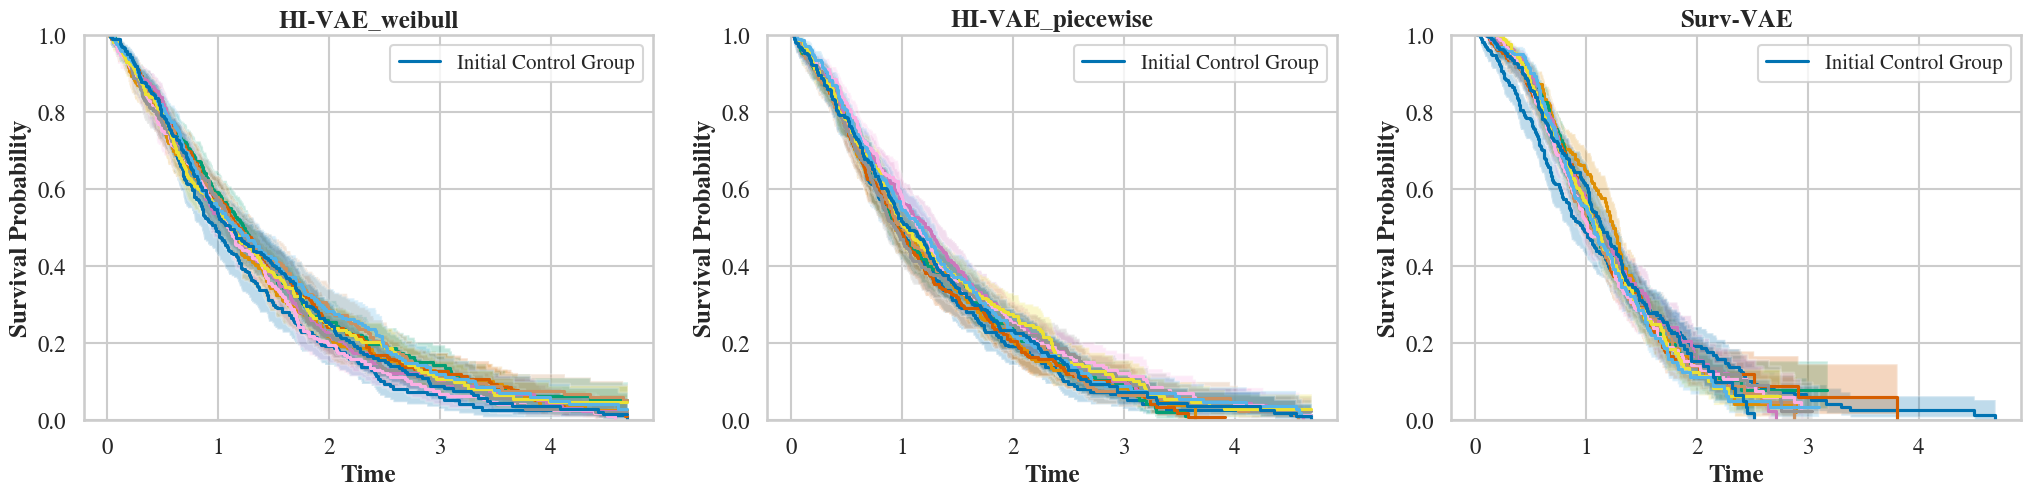

Monte-Carlo experiment 19
Epoch: [ 0]  time: 0.0382, ELBO_train: -16.24702644, KL_z: 2.46142673, KL_s: 0.10472107, reconstruction loss: -13.68087864
Epoch: [100]  time: 0.9966, ELBO_train: -12.44151497, KL_z: 1.22423351, KL_s: 0.03054142, reconstruction loss: -11.18674004
Epoch: [200]  time: 1.7347, ELBO_train: -11.95236683, KL_z: 1.26177573, KL_s: 0.01777935, reconstruction loss: -10.67281175
Epoch: [300]  time: 2.5038, ELBO_train: -12.14251614, KL_z: 1.33095503, KL_s: 0.01520348, reconstruction loss: -10.79635763
Epoch: [400]  time: 3.2526, ELBO_train: -12.10944176, KL_z: 1.40202045, KL_s: 0.01509571, reconstruction loss: -10.69232559
Epoch: [500]  time: 4.0060, ELBO_train: -11.92452908, KL_z: 1.43851149, KL_s: 0.01492834, reconstruction loss: -10.47108924
Epoch: [600]  time: 4.7609, ELBO_train: -11.93408298, KL_z: 1.55635381, KL_s: 0.01431799, reconstruction loss: -10.36341119
Epoch: [700]  time: 5.5744, ELBO_train: -11.64738464, KL_z: 1.73450553, KL_s: 0.01457977, reconstruction lo

[2025-06-26T12:22:37.361898+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-06-26T12:22:37.381477+0200][98645][CRITICAL] module disabled: /Users/vantnguy/Working/HI-VAE_ext/.venv_HI_VAE_ext/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
100%|██████████| 400/400 [00:07<00:00, 51.72it/s]


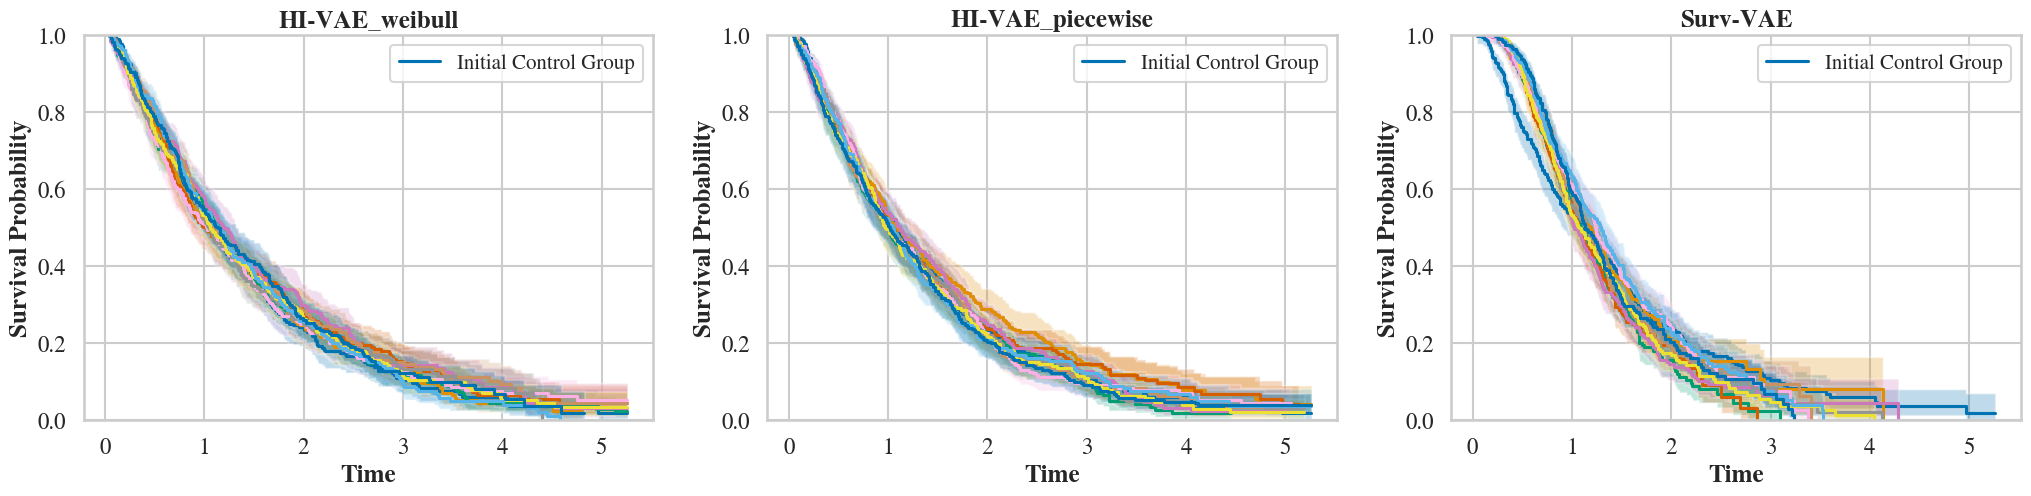

In [15]:
# MONTE-CARLO EXPERIMENT
n_MC_exp = 20
treat_effects = np.arange(0., 1.1, 0.2)
epochs = 10000

synthcity_metrics_sel = ['J-S distance', 'KS test', 'Survival curves distance',
                            'Detection XGB', 'NNDR', 'K-map score']

# Initialize storage for metrics and results
synthcity_metrics_res_dict = {generator_name: pd.DataFrame() for generator_name in generators_sel}
log_p_value_gen_dict = {generator_name: [] for generator_name in generators_sel}
log_p_value_control_dict = {generator_name: [] for generator_name in generators_sel}
est_cox_coef_gen_dict = {generator_name: [] for generator_name in generators_sel}
est_cox_coef_se_gen_dict = {generator_name: [] for generator_name in generators_sel}

# Initialize result variables for MC experiment
simu_num = []
D_control = []
D_treated = []
coef_init_univ_list = []
H0_coef = []
log_p_value_init = []
est_cox_coef_init = []
est_cox_coef_se_init = []

# Perform Monte Carlo experiment
seed = 0
for m in np.arange(n_MC_exp):
    if m % 1 == 0:
        print(f"Monte-Carlo experiment {m}")

    # To make sure the difference between simulated datasets, increase seed value each time
    seed += 1
    # Simulate control group data
    treatment_effect = 0.0
    control, _, types = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                    n_features_bytype, n_active_features, p_treated, shape_T,
                                    shape_C, scale_C, scale_C_indep, data_types_create, seed=seed)
    control = control.drop(columns='treatment')

    data_file_control = os.path.join(f"./dataset/{dataset_name}", "data_control.csv")
    feat_types_file_control = os.path.join(f"./dataset/{dataset_name}", "data_types_control.csv")
    control.to_csv(data_file_control, index=False, header=False)
    types.to_csv(feat_types_file_control, index=False)

    # Load and process control data
    df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(
        data_file_control, feat_types_file_control, miss_file="Missing.csv", true_miss_file=None)
    data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
    data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

    # Format control data into DataFrame
    df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
    df_init_control["treatment"] = 0

    df_gen_control_dict ={}
    # For each generator, perform the data generation with the best and default params
    for generator_name in generators_sel:
        best_params = best_params_dict[generator_name]
        if generator_name in ["HI-VAE_weibull", "HI-VAE_piecewise", "HI-VAE_lognormal"]:
            feat_types_dict_ext = adjust_feat_types_for_generator(generator_name, feat_types_dict)
            data_gen_control = generators_dict[generator_name].run(df_init_control_encoded, miss_mask_control,
                                                                    true_miss_mask_control, feat_types_dict_ext,
                                                                    n_generated_dataset, params=best_params,
                                                                    epochs=epochs)
        else:
            data_gen_control = generators_dict[generator_name].run(data_init_control, columns=fnames,
                                                                    target_column="censor", time_to_event_column="time",
                                                                    n_generated_dataset=n_generated_dataset,
                                                                    params=best_params)

        list_df_gen_control = []
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control["treatment"] = 0
            list_df_gen_control.append(df_gen_control)
        df_gen_control_dict[generator_name] = list_df_gen_control
        
        # Save generated data and compute metrics
        synthcity_metrics_res = general_metrics(df_init_control, list_df_gen_control, generator_name)[synthcity_metrics_sel]
        synthcity_metrics_res_ext = pd.concat([synthcity_metrics_res] * len(treat_effects))
        synthcity_metrics_res_dict[generator_name] = pd.concat([synthcity_metrics_res_dict[generator_name], 
                                                                synthcity_metrics_res_ext])

    # Compare the performance of generation in terms of p-values between generated control and treated group
    for t, treatment_effect in enumerate(treat_effects):

        coef_init_univ = true_univ_coef(treatment_effect, independent, feature_types_list,
                                        n_features_bytype, n_active_features, p_treated, shape_T,
                                        shape_C, scale_C, scale_C_indep, data_types_create, seed=seed)

        control, treated, _ = simulation(treatment_effect, n_samples, independent, feature_types_list,
                                    n_features_bytype, n_active_features, p_treated, shape_T,
                                    shape_C, scale_C, scale_C_indep, data_types_create, seed=seed)
        treated = treated.drop(columns='treatment')

        data_file_treated = os.path.join(f"./dataset/{dataset_name}", "data_treated.csv")
        feat_types_file_treated = os.path.join(f"./dataset/{dataset_name}", "data_types_treated.csv")
        treated.to_csv(data_file_treated, index=False, header=False)
        types.to_csv(feat_types_file_treated, index=False)

        # Load and process treated data
        df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                        miss_file="Missing.csv", true_miss_file=None)
        data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_treated["treatment"] = 1

        # Combine control and treated data
        df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)
        columns = ['time', 'censor', 'treatment']
        coef_init, _, _, se_init = fit_cox_model(df_init, columns)
        est_cox_coef_init += [coef_init[0]] * n_generated_dataset
        est_cox_coef_se_init += [se_init[0]] * n_generated_dataset

        # Compute log-rank test p-value for initial control group vs initial treated group
        p_value_init = compute_logrank_test(df_init_control, df_init_treated)
        log_p_value_init += [p_value_init] * n_generated_dataset
        H0_coef += [treatment_effect] * n_generated_dataset
        simu_num += [m * len(treat_effects) + t] * n_generated_dataset
        D_control += [control['censor'].sum()] * n_generated_dataset
        D_treated += [treated['censor'].sum()] * n_generated_dataset
        coef_init_univ_list += [coef_init_univ] * n_generated_dataset

        # For each generator, compute the log-rank test p-values and Cox coefficients for generated control group vs initial treated group
        for generator_name in generators_sel:
            log_p_value_gen_list = []
            log_p_value_control_list = []
            est_cox_coef_gen = []
            est_cox_coef_se_gen = []
            for i in range(n_generated_dataset):
                df_gen_control = df_gen_control_dict[generator_name][i]
                log_p_value_gen_list.append(compute_logrank_test(df_gen_control, treated))
                log_p_value_control_list.append(compute_logrank_test(df_gen_control, control))
                df_gen = pd.concat([df_gen_control, df_init_treated], ignore_index=True)
                coef_gen, _, _, se_gen = fit_cox_model(df_gen, columns)
                est_cox_coef_gen.append(coef_gen[0])
                est_cox_coef_se_gen.append(se_gen[0])

            log_p_value_gen_dict[generator_name] += log_p_value_gen_list
            log_p_value_control_dict[generator_name] += log_p_value_control_list
            est_cox_coef_gen_dict[generator_name] += est_cox_coef_gen
            est_cox_coef_se_gen_dict[generator_name] += est_cox_coef_se_gen

    fig, axs = plt.subplots(1, len(generators_sel), figsize=(25, 5))
    for i, generator_name in enumerate(generators_sel):
        kaplan_meier_estimation(df_init_control, label="Initial Control Group", ax=axs[i])
        for j in range(10):
            compute_logrank_test(df_gen_control_dict[generator_name][j], treated)
            df_syn_sel = pd.DataFrame(df_gen_control_dict[generator_name][j], columns=fnames)
            kaplan_meier_estimation(df_syn_sel, label="", ax=axs[i])

        axs[i].set_ylim(0, 1)
        axs[i].legend(fontsize=15)
        axs[i].set_xlabel("Time", fontweight="semibold")
        axs[i].set_ylabel("Survival Probability", fontweight="semibold")
        axs[i].set_title(generator_name, fontweight="bold")
    plt.show()

# Save the results
results = pd.DataFrame({'XP_num': simu_num, 'D_control': D_control, 'D_treated': D_treated,
                        'H0_coef_univ': coef_init_univ_list, 'H0_coef': H0_coef,
                        'log_pvalue_init': log_p_value_init, 'est_cox_coef_init': est_cox_coef_init,
                        'est_cox_coef_se_init': est_cox_coef_se_init})

for generator_name in generators_sel:
    results[f"log_pvalue_{generator_name}"] = log_p_value_gen_dict[generator_name]
    results[f"log_pvalue_control_{generator_name}"] = log_p_value_control_dict[generator_name]
    results[f"est_cox_coef_{generator_name}"] = est_cox_coef_gen_dict[generator_name]
    results[f"est_cox_coef_se_{generator_name}"] = est_cox_coef_se_gen_dict[generator_name]
    for metric in synthcity_metrics_sel:
        results[f"{metric}_{generator_name}"] = synthcity_metrics_res_dict[generator_name][metric].values


In [16]:
results.to_csv(f"./dataset/{dataset_name}/results_{metric_optuna}_n_samples_{n_samples}_n_features_bytype_{n_features_bytype}.csv")

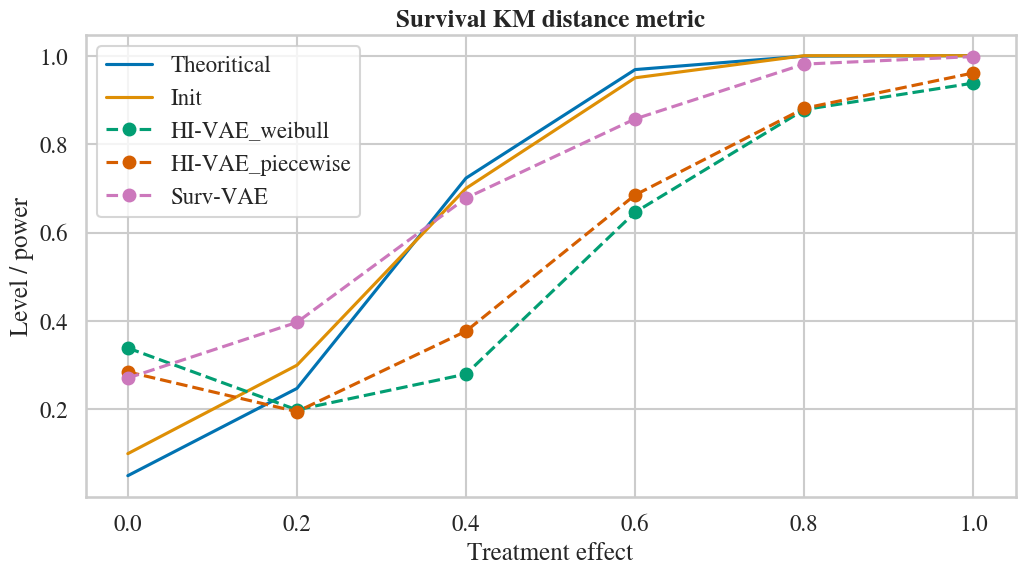

In [17]:
results_kmdist_ext = results
fig, ax = plt.subplots(figsize=(12, 6))
H0_coef_univ_theo = results_kmdist_ext.groupby("H0_coef").mean()["H0_coef_univ"].to_numpy()
D_control_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_control"].to_numpy()
D_treated_theo = results_kmdist_ext.groupby("H0_coef").mean()["D_treated"].to_numpy()
power_theo = []
for i in range(len(H0_coef_univ_theo)):
    power_theo.append(cpower(D_control_theo[i], D_treated_theo[i], H0_coef_univ_theo[i], 0.05))
ax.plot(treat_effects, np.array(power_theo), label = "Theoritical")

results_kmdist_ext["reject_H0_init"] = results_kmdist_ext['log_pvalue_init'] > -np.log(0.05)
power_init = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
ax.plot(treat_effects, power_init, '-', label = "Init")

custom_palette = ['deepskyblue','darkblue','orange', 'red']
for i, generator_name in enumerate(generators_sel):
    results_kmdist_ext["reject_H0_gen_" + generator_name] = results_kmdist_ext['log_pvalue_' + generator_name] > -np.log(0.05)
    power_gen = results_kmdist_ext.groupby("H0_coef").mean()["reject_H0_gen_" + generator_name].to_numpy()
    ax.plot(treat_effects, power_gen, '--', marker='o', label = generator_name,)

plt.xlabel("Treatment effect")
plt.ylabel("Level / power")
plt.title("Survival KM distance metric", fontweight='semibold')
plt.legend()
plt.show()

In [18]:
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

def visualize_synthcity_metric_res(results, metrics, title):
    num_metrics = len(metrics)
    n_learners = len(generators_sel)
    fig, axs = plt.subplots(1, num_metrics, figsize=(5 * num_metrics * n_learners, 10))

    if num_metrics == 1:
        axs = [axs]  # ensure axs is iterable

    for i, ax in enumerate(axs):
        # Format axis spines
        metric_name, opt = metrics[i]
        metric_df = pd.DataFrame()
        for generator_name in generators_sel:
            metric_df = pd.concat([metric_df, pd.DataFrame(np.array([[generator_name] * results.shape[0], 
                                                            results[metric_name + "_" + generator_name]]).T,
                                                            columns=['generator', metric_name])])
        metric_df[metric_name] = np.float64(metric_df[metric_name].values)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_edgecolor('black')

        sns.boxplot(data=metric_df, x='generator', y=metric_name, ax=ax,
                    linewidth = 3, saturation = 1, palette = 'colorblind', 
                    width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
        ax.set_xlabel('')
        ax.set_ylabel(metric_name, fontsize=30, fontweight="semibold")
        ax.tick_params(axis='x', labelsize=25)
        ax.tick_params(axis='y', labelsize=25)
        if opt == "max":
            ax.legend(title='Maximize \u2191', title_fontsize=15)
        else:
            ax.legend(title='Minimize \u2193', title_fontsize=15)
    plt.tight_layout(pad=3)
    fig.suptitle(title, fontsize=35, fontweight='semibold')

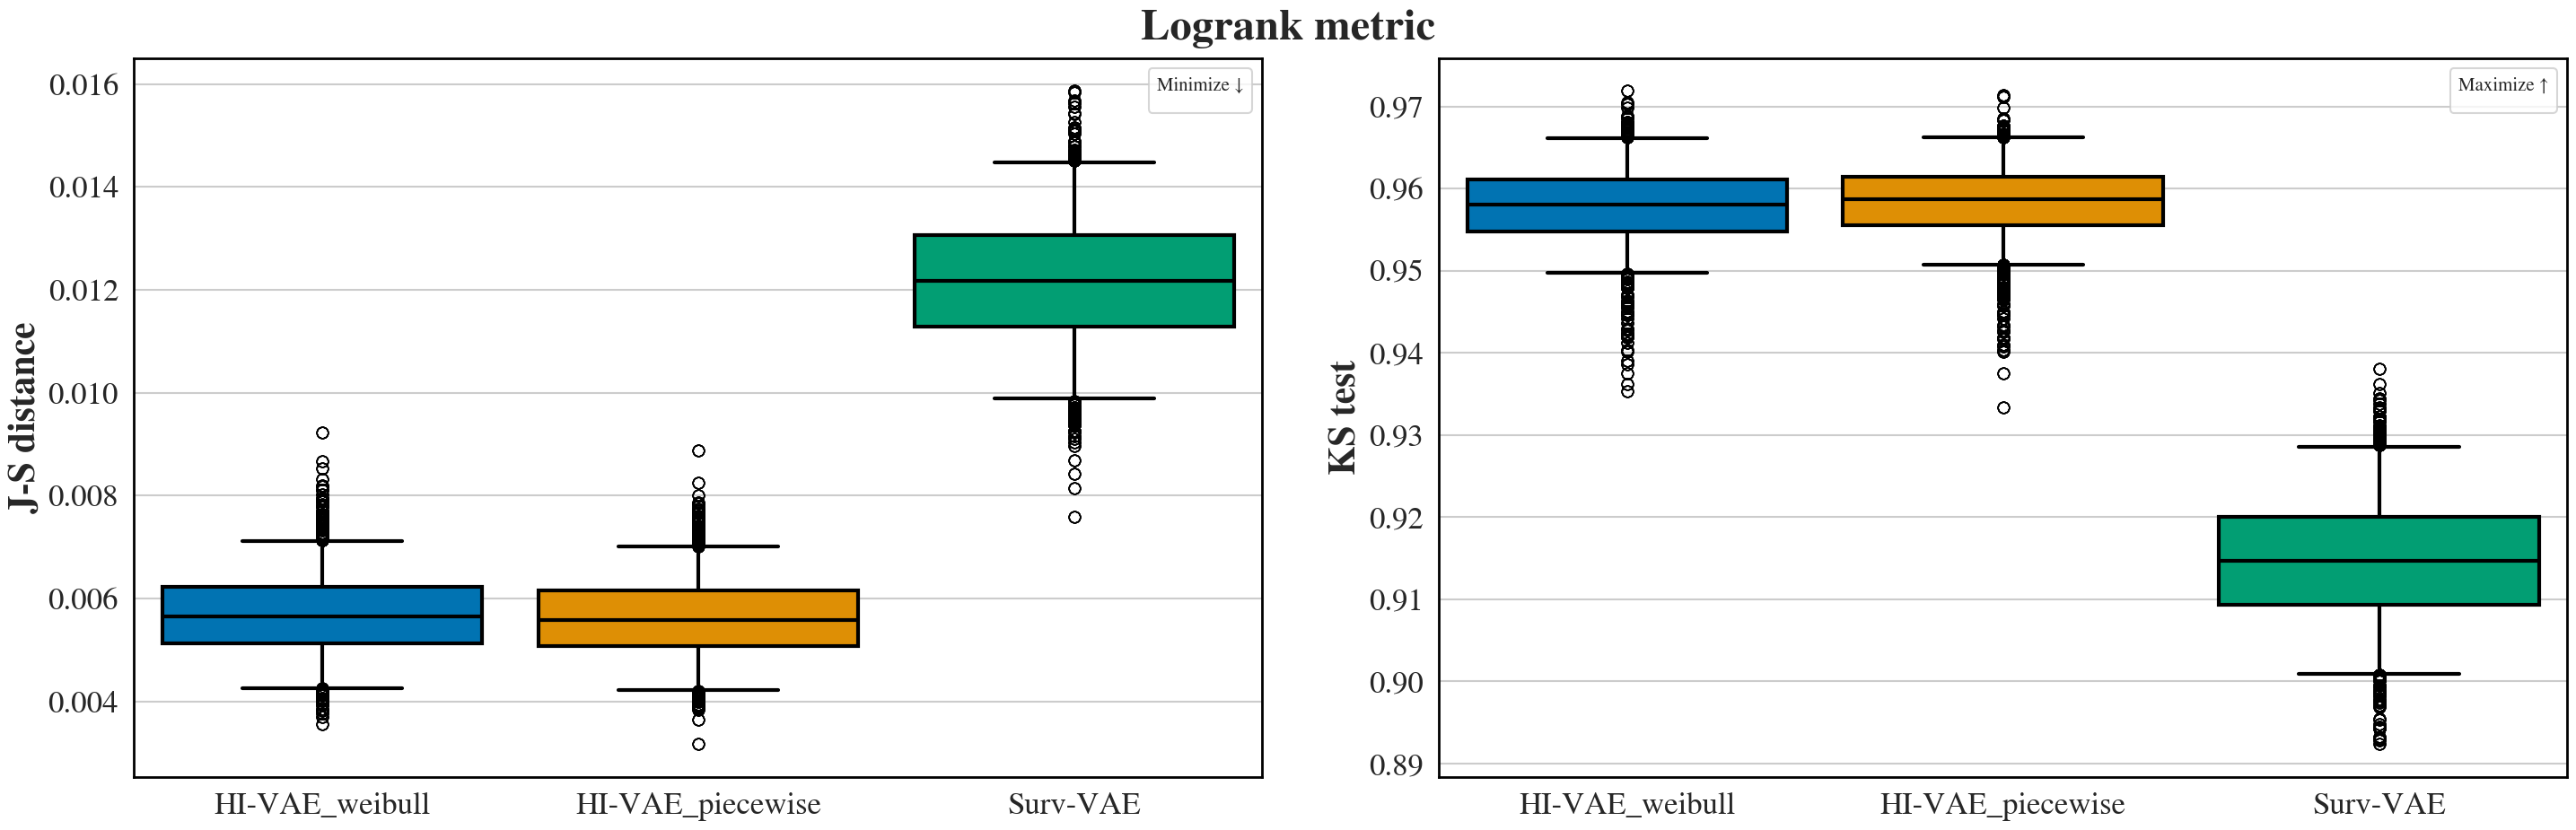

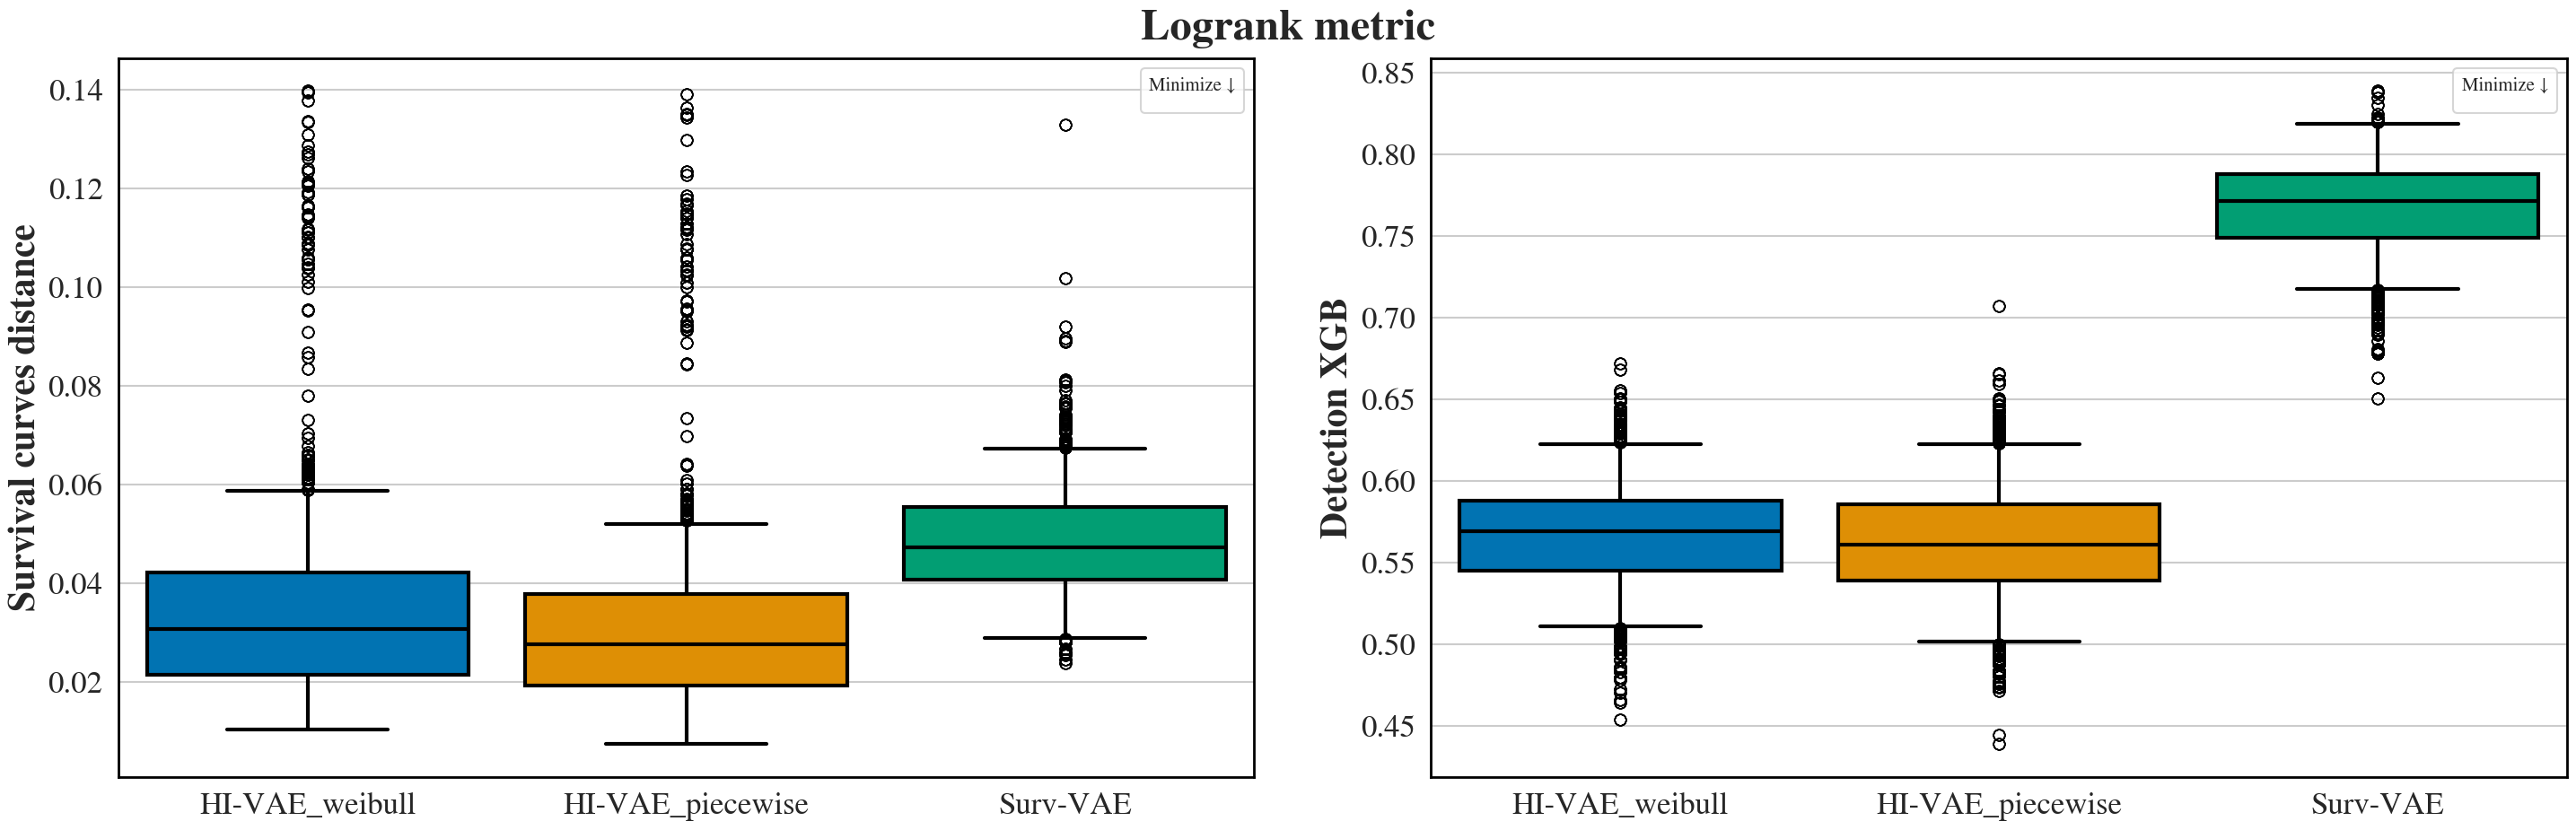

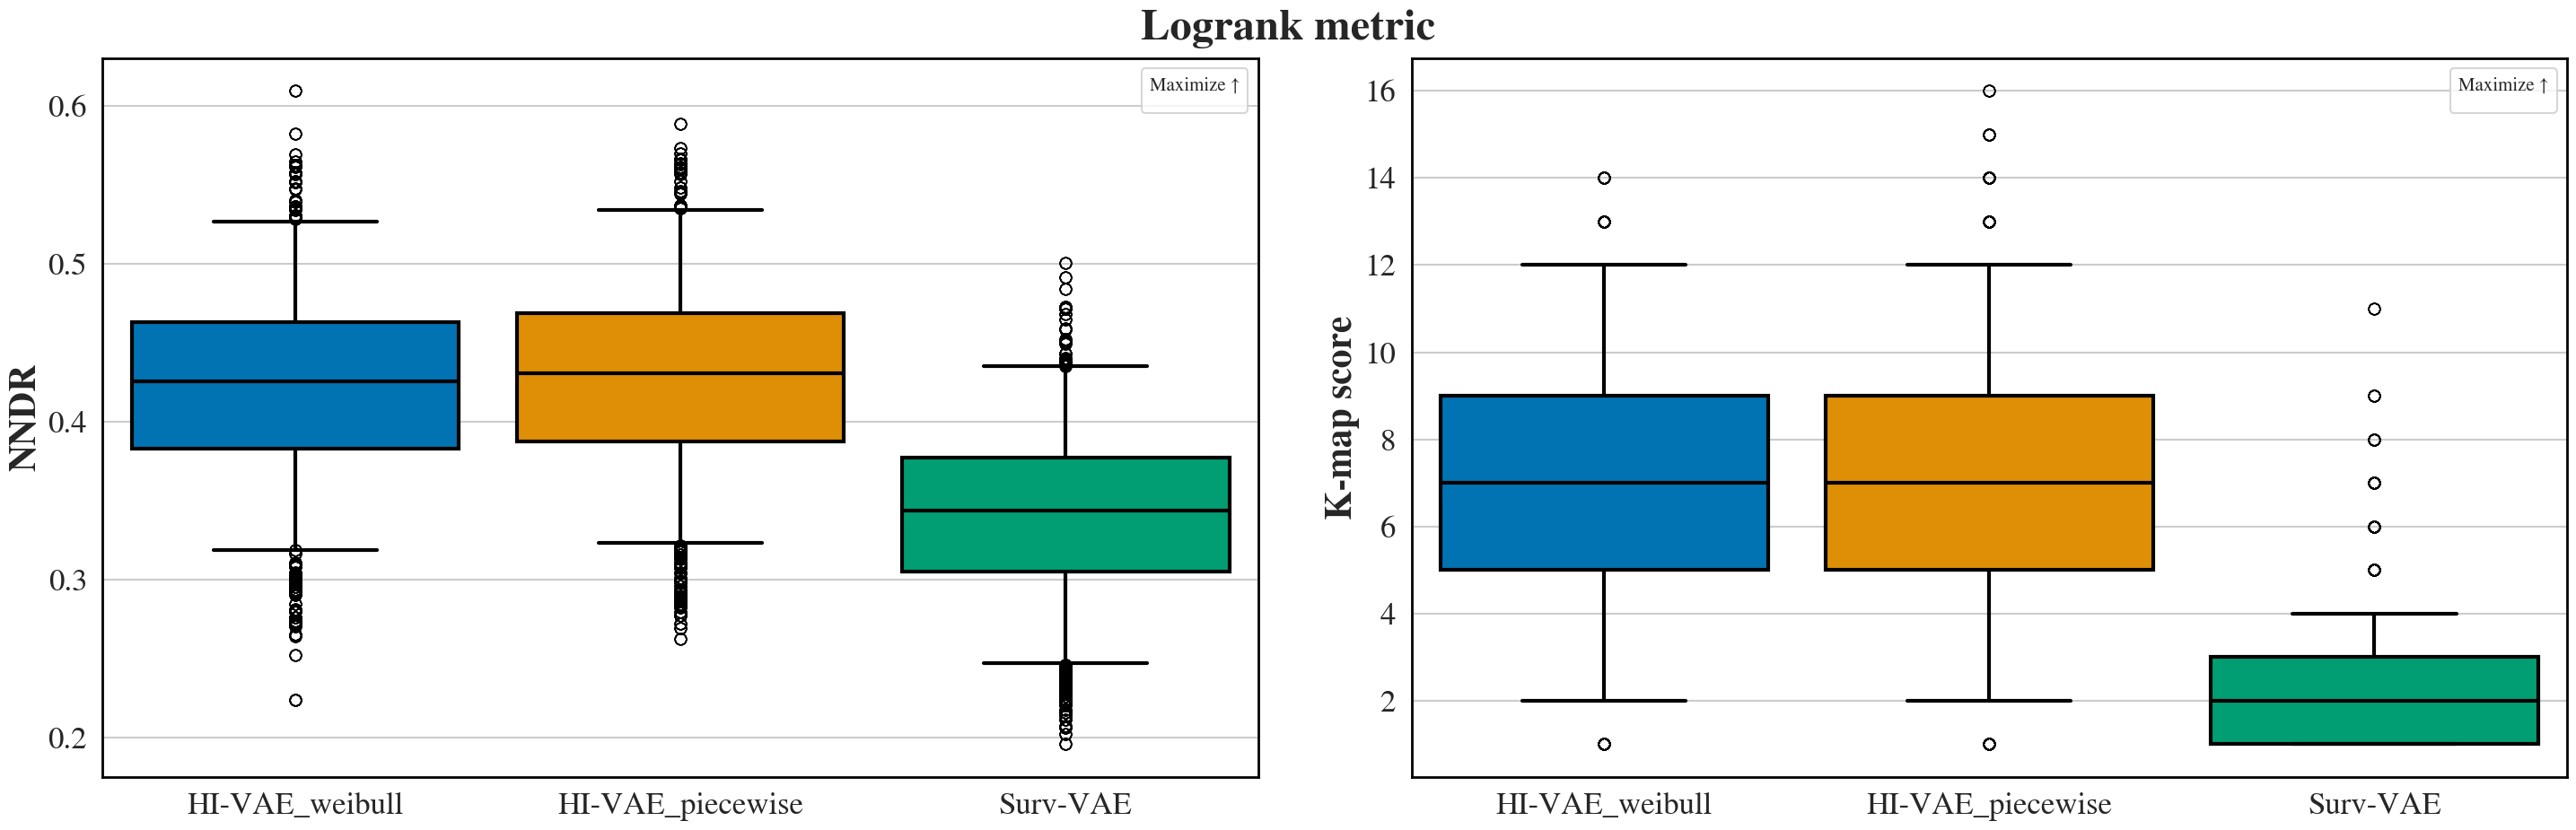

In [19]:
for metrics in [[['J-S distance', "min"], ['KS test', "max"]],
                [['Survival curves distance', "min"], ['Detection XGB', "min"]],
                [['NNDR', "max"], ['K-map score', "max"]]]:
    visualize_synthcity_metric_res(results_kmdist_ext, metrics, 'Logrank metric')

In [20]:
metric_control_df = pd.DataFrame()
for generator_name in generators_sel:
    metric_control_df = pd.concat([metric_control_df, pd.DataFrame(np.array([[generator_name] * results_kmdist_ext.shape[0], 
                                                            results_kmdist_ext["log_pvalue_control_" + generator_name]]).T,
                                                            columns=['generator', 'log_pvalue'])])

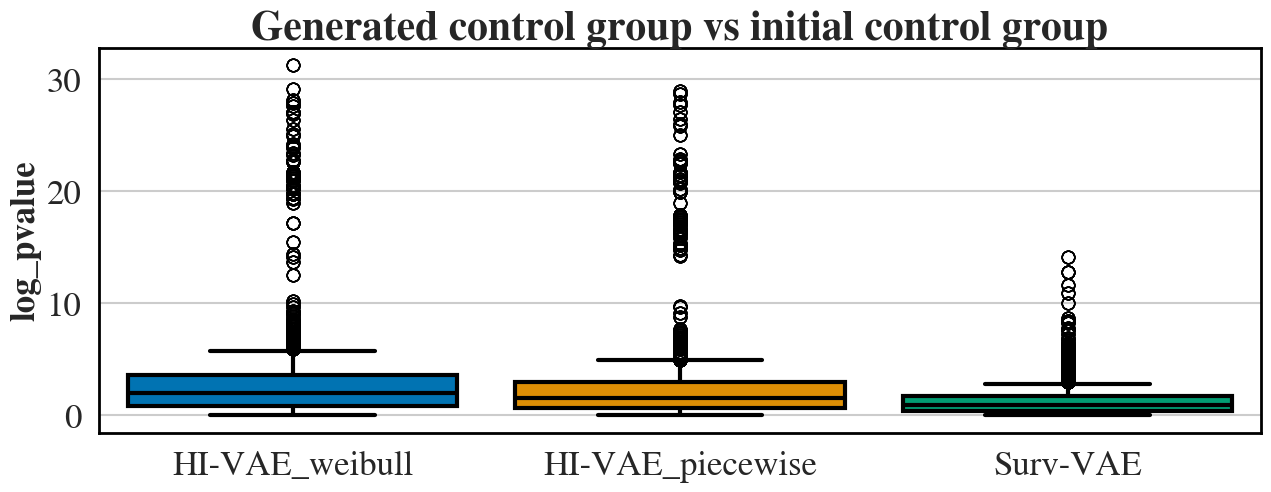

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

metric_control_df['log_pvalue'] = np.float64(metric_control_df['log_pvalue'].values)
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_edgecolor('black')

sns.boxplot(data=metric_control_df, x='generator', y='log_pvalue', ax=ax,
            linewidth = 3, saturation = 1, palette = 'colorblind', 
            width = 1, gap = 0.15, whis = 0.8, linecolor="Black")
ax.set_xlabel('')
ax.set_ylabel('log_pvalue', fontsize=25, fontweight="semibold")
ax.set_title('Generated control group vs initial control group', fontsize=30, fontweight="semibold")
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)